In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import sys
#sys.path.append('../../')
#from pydicts.obsdict import get_FINO_obs
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv,w_s,T_d
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from mmctools.helper_functions import calc_wind
from mmctools.plotting import TaylorDiagram
import wrf
from netCDF4 import Dataset
import matplotlib.colors as colors
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import matplotlib.patches as patches
from string import ascii_lowercase

In [3]:
scratch_dir = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/'
work_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'

wrf_dir = scratch_dir

restarts = ['ERAI_20190715', 'ERAI_20190717', 'ERAI_20190719', 'ERAI_20190721', 
            'ERAI_20190723', 'ERAI_20190725', 'ERAI_20190727', 'ERAI_20190729']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


# Where to save the images:

In [4]:
#save_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/'
save_dir = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/img/'
save_figs = True

In [5]:
import sys
sys.path.append('/glade/u/home/hawbecke/Code/Python/')
from publications.Chesapeake.BayBreezeObservedDates import bb_observed_dates
from publications.Chesapeake.CBB_case_dict import case_dict
cases = list(case_dict.keys())
cases = cases[3:-4]

ncases   = len(cases)
case_dom = [3]*ncases

show_plot = True
init_vars = True

check_clouds = True
check_rain = True


breeze_ds_dict = {}
for cc,case in enumerate(cases):
    #breeze_ds_path = '{}{}/spatial_breeze_detection_CLDnRAIN_d0{}.nc'.format(wrf_dir,case,case_dom[cc])
    breeze_ds_path = '{}{}/spatial_breeze_detection_CLDnRAIN_d0{}_abs.nc'.format(wrf_dir,case,case_dom[cc])
    print(breeze_ds_path)
    if path.exists(breeze_ds_path):
        print('Numerical detection dataset already created!')
        breeze_ds_f = xr.open_dataset(breeze_ds_path)
        breeze_ds_dict[case] = breeze_ds_f
    else:
        print('No detection dataset... run NumericalBreezeDetection.py')

t_s = pd.to_datetime(breeze_ds_dict[cases[0]].datetime[0].data)
t_e = pd.to_datetime(breeze_ds_dict[cases[0]].datetime[-1].data)

/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/DEFLT_NOFL_NOSK/spatial_breeze_detection_CLDnRAIN_d03_abs.nc
Numerical detection dataset already created!
/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/DEFLT_NOFL_SKNT/spatial_breeze_detection_CLDnRAIN_d03_abs.nc
Numerical detection dataset already created!
/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/DEFLT_FILL_NOSK/spatial_breeze_detection_CLDnRAIN_d03_abs.nc
Numerical detection dataset already created!
/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/DEFLT_FILL_SKNT/spatial_breeze_detection_CLDnRAIN_d03_abs.nc
Numerical detection dataset already created!
/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/G1SST_NOFL_NOSK/spatial_breeze_detection_CLDnRAIN_d03_abs.nc
Numerical detection dataset already created!
/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIV

In [6]:
all_observed_dates = {}
detection_f_names = ['RealSampleRate','RealSampleRate_NumericalMinMax']
for detection_f_name in detection_f_names:
    if 'NumericalMinMax' in detection_f_name:
        bb_observed_dates_list = bb_observed_dates['NumericalMinMax']
    else:
        bb_observed_dates_list = bb_observed_dates['orig']
    for mm,method in enumerate(bb_observed_dates_list.keys()):
        if mm == 0:
            all_observed_dates_f = bb_observed_dates_list[method].copy()
        else:
            for day in bb_observed_dates_list[method]:
                if day not in list(all_observed_dates_f):
                    all_observed_dates_f[day] = bb_observed_dates_list[method][day]
                else: # check to see if the station on this date is already included
                    if bb_observed_dates_list[method][day] != all_observed_dates_f[day]:
                        new_list = list(np.unique(np.append(bb_observed_dates_list[method][day], all_observed_dates_f[day])))
                        all_observed_dates_f[day] = new_list
    if 'NumericalMinMax' in detection_f_name:
        detect_name = 'NumericalMinMax'
    else:
        detect_name = 'orig'
    all_observed_dates[detect_name] = all_observed_dates_f
    for day in all_observed_dates[detect_name]:
        print(day,all_observed_dates[detect_name][day])
    print('\n\n\n')

2019-07-01 ['NAK']
2019-07-02 ['MTN', 'APG']
2019-07-04 ['NHK', 'NUI']
2019-07-06 ['MTN', 'APG']
2019-07-09 ['NAK', 'MTN']
2019-07-10 ['NHK', 'NUI']
2019-07-15 ['NAK']
2019-07-16 ['MTN', 'NAK', 'NHK']
2019-07-17 ['MTN', 'NAK']
2019-07-19 ['APG', 'MTN', 'NAK', 'NHK']
2019-07-22 ['MTN']
2019-07-24 ['NAK', 'NUI']
2019-07-25 ['NAK']
2019-07-26 ['MTN', 'BWI']
2019-07-27 ['MTN', 'NAK', 'NHK']
2019-07-28 ['MTN', 'NAK', 'NHK']
2019-07-29 ['MTN', 'NAK', 'NHK']
2019-07-30 ['MTN', 'NAK', 'NHK']
2019-07-31 ['NHK']
2019-07-05 ['BWI']




2019-07-01 ['NAK']
2019-07-02 ['MTN', 'APG']
2019-07-04 ['NHK', 'NUI']
2019-07-06 ['APG', 'MTN', 'NUI']
2019-07-09 ['NAK', 'MTN']
2019-07-10 ['NHK', 'NUI']
2019-07-15 ['NAK']
2019-07-16 ['MTN', 'NAK', 'NHK']
2019-07-17 ['MTN', 'NAK', 'NUI']
2019-07-19 ['APG', 'MTN', 'NAK', 'NHK']
2019-07-22 ['MTN', 'NUI']
2019-07-24 ['NAK', 'NUI']
2019-07-25 ['NAK']
2019-07-26 ['MTN', 'BWI']
2019-07-27 ['MTN', 'NAK', 'NHK', 'NUI']
2019-07-28 ['NAK', 'NHK']
2019-07-29 ['MTN', 'NAK',

# Load in observations:

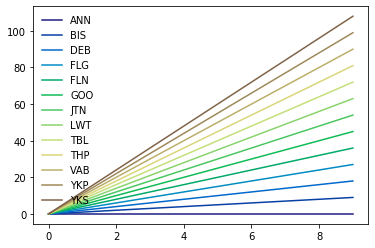

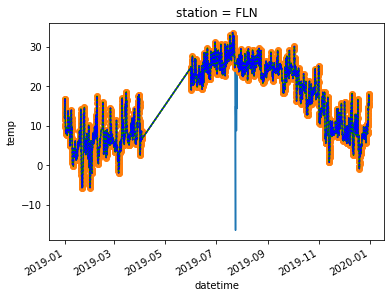

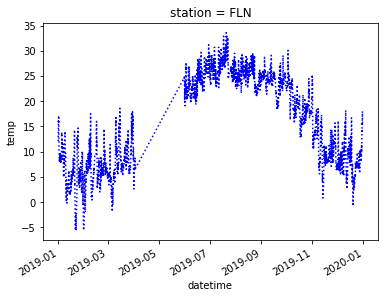

In [7]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
buoy_ds = xr.open_dataset(buoy_f)

buoy_loc_dict = {}
for buoyn in buoy_ds.station.data:
    buoy_loc_dict[buoyn] = {'lat':float(buoy_ds.sel(station=buoyn).lat.data),
                     'lon':float(buoy_ds.sel(station=buoyn).lon.data)}

buoy_list = list(buoy_loc_dict.keys())

buoy_loc_dict['JTN']['lat'] = 37.21137
buoy_loc_dict['JTN']['lon'] = -76.78677

bad_buoys = ['PMC','GRF','SRP','CAM','SLM','WDC']

for bad_buoy in bad_buoys:
    buoy_list.remove(bad_buoy)

buoy_colors = {}
for bb,buoyn in enumerate(buoy_list):
    line_cols = plt.cm.terrain(np.linspace(0.0,0.7,len(buoy_list)))[bb]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    buoy_colors[buoyn] = line_cols
for bb,buoyn in enumerate(buoy_list):
    plt.plot(np.arange(0,10),np.arange(0,10)*bb,c=buoy_colors[buoyn],label=buoyn)
plt.legend(frameon=False)
plt.show()

if 'FLN' in buoy_ds.station.data:
    temp_obs = buoy_ds.temp.copy()
    buoy_ds = buoy_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    t_s = buoy_ds.datetime[0]
    t_e = buoy_ds.datetime[-1]
    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot()

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']

    #rem_starts = ['2019-07-23 18:00:00']
    #rem_ends = ['2019-07-27 01:45:00']
    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan


    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(marker='o')

    temp_obs.sel(station='FLN').data = fln.data
    
    temp_obs.sel(station='FLN').sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(c='g')
    buoy_ds['temp'] = temp_obs

    buoy_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')
    plt.show()
    buoy_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')


In [8]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))

# Add APG data into AWOS
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})
non_apg_list = apg_stn_list.copy()
non_apg_list.remove('APG')
apg_ds = apg_ds.drop_sel(station=non_apg_list)
apg_ds = apg_ds.drop(['rh','gust','radt','rain','alt'])

temp = awos_ds.sel(station='APG').combine_first(apg_ds)
temp = temp.squeeze()
temp = temp.expand_dims('station')

lat_da = xr.DataArray([float(apg_ds.lat)], dims=('station'))
lon_da = xr.DataArray([float(apg_ds.lon)], dims=('station'))

temp = temp.assign_coords({'lat':lat_da})
temp = temp.assign_coords({'lon':lon_da})

awos_ds = awos_ds.drop_sel(station=['APG'])

awos_ds = xr.merge([awos_ds,temp])

near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']
inland_station      = ['IAD']

vars_to_compare = {'wspd':'wspd10',
                   'wdir':'wdir10',
                   'temp':'t2'}

for ss,stn in enumerate(near_shore_stations):
    if stn in asos_ds.get_index('station'):
        stn_ds = asos_ds.sel(station=stn)
    elif stn in awos_ds.get_index('station'):
        stn_ds = awos_ds.sel(station=stn)
    #elif stn in apg_ds.get_index('station'):
    #    stn_ds = apg_ds.sel(station=stn)
    else:
        print('no obs for this station: {}'.format(stn))
    if stn == 'APG':
        stn_ds = apg_ds.sel(station='APG')
        stn_ds.station.data = 'APG'

    obs_res = stn_ds.copy().sel(datetime=slice(t_s,t_e))
    for dd in obs_res.data_vars:
        if dd not in vars_to_compare:
            obs_res = obs_res.drop_vars(dd)
    obs_res = obs_res.resample(datetime='5min').nearest(tolerance='5min')
    if ss == 0:
        obs_res_full = obs_res
    else:
        obs_res_full = xr.concat([obs_res_full,obs_res],dim='station')


shallow_buoys = buoy_list.copy()

shallow_buoys.remove('DEB')
shallow_buoys.remove('VAB')


# Get day of interest variables:

In [9]:
day_of_interest = '2019-07-16 20:00:00'
case_of_interest = cases[0]
#wrf_dir = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/'
wrfout_files = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,case_of_interest,restarts[0],case_dom[0])))

for wrfout_file in wrfout_files:
    if day_of_interest.replace(' ','_') in wrfout_file:
        file_of_interest = wrfout_file

wrfout = xr.open_dataset(file_of_interest,decode_times=False).sel(Time=0)
wrfout = np.squeeze(wrfout)
wrfinput = xr.open_dataset('{}{}/{}/wrfinput_d0{}'.format(wrf_dir,cases[0],restarts[0],case_dom[0]))

land_mask  = np.squeeze(wrfinput.LANDMASK)
hgt        = np.squeeze(wrfinput.HGT)
water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
lat  = wrfout.XLAT
lon  = wrfout.XLONG

nx = len(wrfout.west_east)
ny = len(wrfout.south_north)
dx = wrfout.DX/1000.0
dy = wrfout.DY/1000.0
x = np.arange(0,nx)*dx
y = np.arange(0,nx)*dy
xy,yx = np.meshgrid(x,y)

t2   = wrfout.T2.where(land_mask == 1.0)
u10  = wrfout.U10.where(land_mask == 1.0)
v10  = wrfout.V10.where(land_mask == 1.0)
sfcP = wrfout.PSFC.where(land_mask == 1.0)
temp = np.squeeze(wrfout.T)
z_f = (np.squeeze(wrfout.PH) + np.squeeze(wrfout.PHB))/9.8 - np.squeeze(wrfout.HGT)
zs_f = 0.5*(z_f[1:,:,:]+z_f[:-1,:,:])

vel10,dir10 = calc_wind(wrfout,u='U10',v='V10')
vel10 = vel10.where(land_mask == 1.0)
dir10 = dir10.where(land_mask == 1.0)

top_ind = 18
bot_ind = 0

u = wrfout.U[top_ind,:,:].data
v = wrfout.V[top_ind,:,:].data

u = 0.5*(u[:,1:] + u[:,:-1])
v = 0.5*(v[1:,:] + v[:-1,:])
wdir1km = 180. + np.degrees(np.arctan2(u, v))

In [10]:
stn_dict = {}
for ss,stn in enumerate(near_shore_stations):
    stn_dict[stn] = {}
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    stn_dict[stn]['lat'] = float(stn_ds.lat.data)
    stn_dict[stn]['lon'] = float(stn_ds.lon.data)
    stn_dict[stn]['i'] = stn_i
    stn_dict[stn]['j'] = stn_j

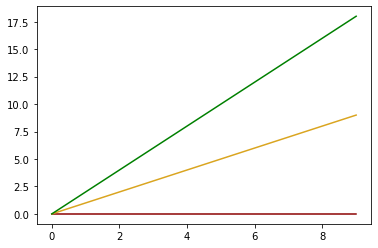

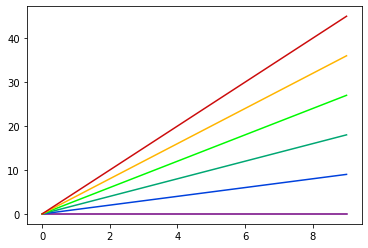

In [11]:
breeze_cmap = plt.cm.RdYlGn(np.linspace(0.1,0.9,3))
breeze_cmap = ['darkred','goldenrod','green']
for ll,lvl in enumerate(np.arange(0,3)):
    plt.plot(np.arange(0,10),np.arange(0,10)*ll,c=breeze_cmap[ll])
plt.show()
stn_colors = plt.cm.nipy_spectral(np.linspace(0.05,0.95,len(near_shore_stations)))
for ss,stn in enumerate(near_shore_stations):    
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[ss])
plt.show()

# Required functions:

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return colors.LinearSegmentedColormap('colormap',cdict,1024)

new_cmap = truncate_colormap(plt.cm.terrain, 0.3, 0.8)
new_cmap.set_bad(color='darkblue')

light_cmap = cmap_map(lambda x: x/4 + 0.75, new_cmap)
light_cmap.set_bad(color='lightsteelblue')
light_cmap.set_bad(color='aliceblue')

def find_max_in_row(x):
    expected_x = x[0] + 1
    count = 1
    max_count = 1
    for i in x[1:]:
        if i == expected_x:
            count += 1
            expected_x += 1
            if count > max_count: max_count = count
        else:
            if count > max_count: max_count = count
            count = 1
            expected_x = i + 1
    return(max_count)

def validate_bay_breeze(bb_day_dict,
                        use_neighbors=False,
                        check_rain_clouds=True,
                        detect_option=1,
                        verbose=False):
    
    neighbor_threshold = 1.0 # Neighbors don't need to average 2... set to something lower
    bb_day        = bb_day_dict['bb_day']
    neighbor_day  = bb_day_dict['neighbor_day']
    cloud_day     = bb_day_dict['cloud_day']
    rain_day      = bb_day_dict['rain_day']
    
    cloud_tot = cloud_day.sum().data
    rain_tot  = rain_day.sum().data
    #if stn == 'MTN' and dd == 1: wefwef


    # Check rain or clouds here:
    if check_rain_clouds:
        # Subtract from bb_day if cloud_day == 1.0
        bb_no_clouds = bb_day * ((cloud_day - 1.0)*-1)
        bb_eq_2 = np.where(bb_no_clouds.data==2.0)[0]
    else:
        bb_eq_2 = np.where(bb_day.data==2.0)[0]


    if len(bb_eq_2) >= 1:
        max_count = find_max_in_row(bb_eq_2)
    else:
        max_count = 0
        
    bb_detected = max_count >= 2
    
    if verbose: print(bb_detected)
        

    if use_neighbors:
        
        good_neighbors = np.where(neighbor_day.data>=neighbor_threshold)[0]    
        if len(good_neighbors) >= 2:
            max_neighbor_count = find_max_in_row(good_neighbors)
        else:
            max_neighbor_count = 0
        if verbose: print('good neighbors: ', max_neighbor_count)
        if detect_option == 1:
            bb_detected = (max_count >= 2) and (max_neighbor_count >= 2)
        elif detect_option == 2:
            bb_detected = (max_count >= 2) and ((max_neighbor_count >= 2) or (neighbor_day.mean() > 0.75))
        elif detect_option == 3:
            if verbose: print(bb_day.mean(),neighbor_day.mean())
            bb_detected = ((max_count >= 2) and (max_neighbor_count >= 2)) or \
                          ((len(np.where(bb_day.data>=1.0)[0])/len(bb_day) >= 0.5) and \
                           (len(np.where(neighbor_day.data>=0.5)[0])/len(neighbor_day) >= 0.5))
        if verbose: print(bb_detected)

            
    if check_rain_clouds:
        # Check for rain today:
        is_rainy = (rain_tot > 1.0)
        if verbose: print('is rainy: ',is_rainy)
        bb_detected = bb_detected and (not is_rainy)
        if verbose: print(bb_detected)

            
            
    return(bb_detected)

                    


def rainbow_text(x,y,ls,lc,align='horizontal',fig=None,ax=None,**kw):
    """
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.
    """
    t = plt.gca().transData
    if fig is None:
        fig = plt.gcf()

    #plt.show()

    if align == 'horizontal':
        for s,c in zip(ls,lc):
            if ax is None:
                text = plt.text(x,y,s+" ",color=c, transform=t, **kw)
            else:
                text = ax.text(x,y,s+" ",color=c, transform=t, **kw)
            text.draw(fig.canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

    if align == 'vertical':
        for s,c in zip(ls,lc):
            text = plt.text(x,y,s+" ",color=c, transform=t,
                    rotation=90,va='bottom',ha='center',**kw)
            text.draw(fig.canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, y=ex.height, units='dots')



def convert_breeze_dict_to_xr(breeze_dict):
    for kk,key in enumerate(breeze_dict.keys()):
        if key == 'breeze':
            var = breeze_dict['good_wdir'].copy()
            var.data = breeze_dict[key]
        else:
            var = breeze_dict[key]
            var.name = key
        if kk == 0:
            ds = xr.Dataset({key: var})
        else:
            ds = xr.merge([ds,var])
            
    ds = ds.expand_dims('datetime')
    dtime = ds.XTIME.expand_dims('datetime')
    ds = ds.drop('XTIME')
    ds['datetime'] = dtime
    return(ds)

# MBDA:

DEFLT_NOFL_NOSK


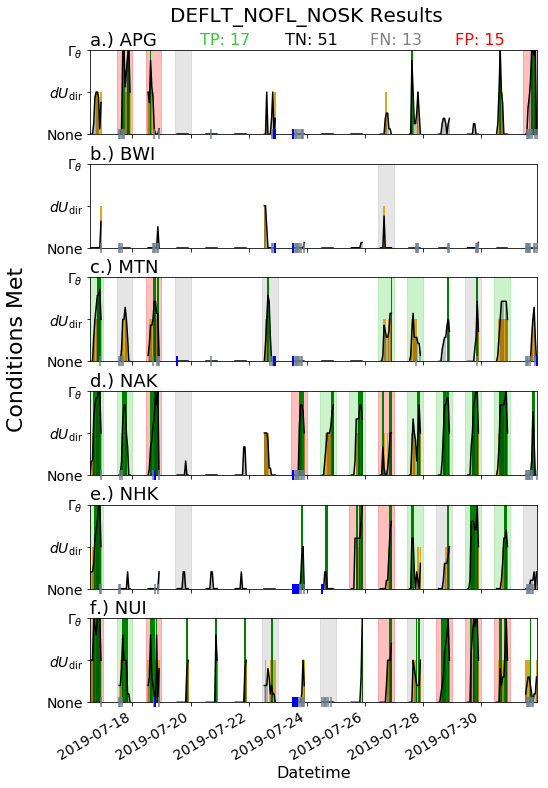

DEFLT_NOFL_SKNT


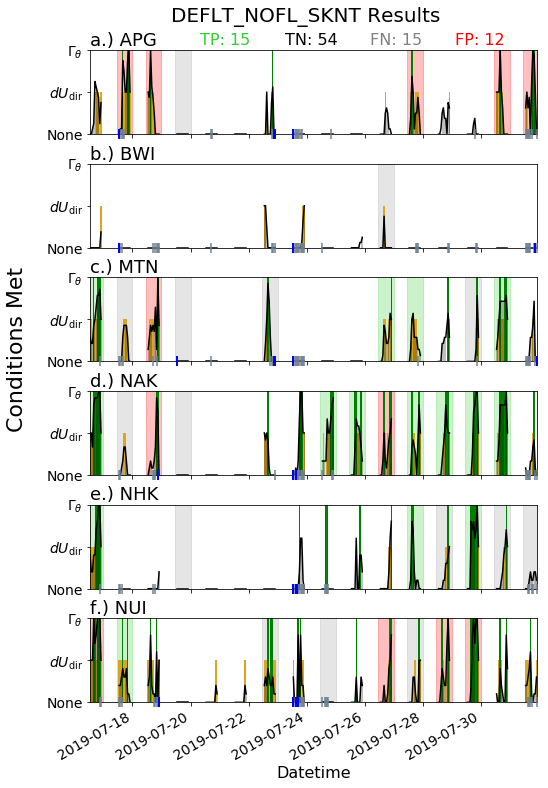

DEFLT_FILL_NOSK


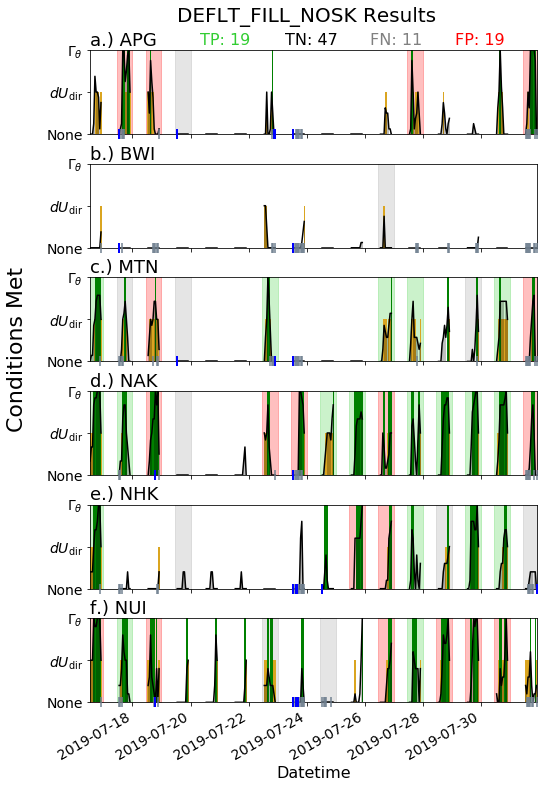

DEFLT_FILL_SKNT


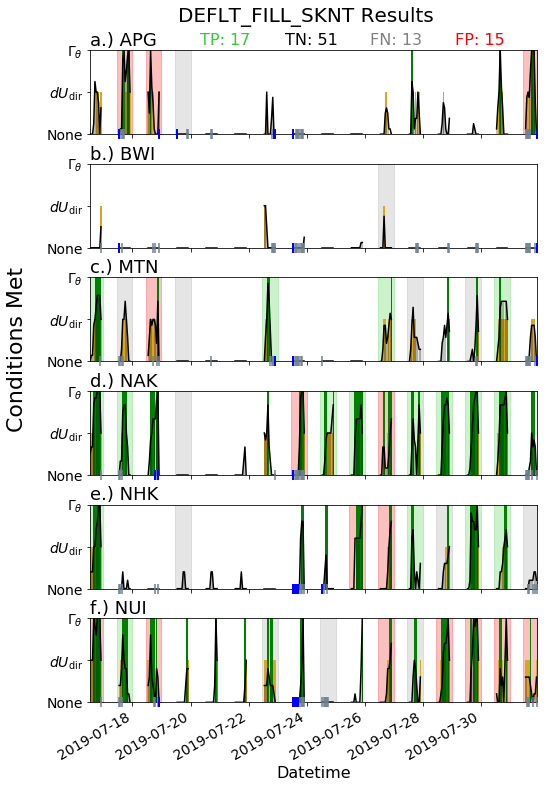

G1SST_NOFL_NOSK


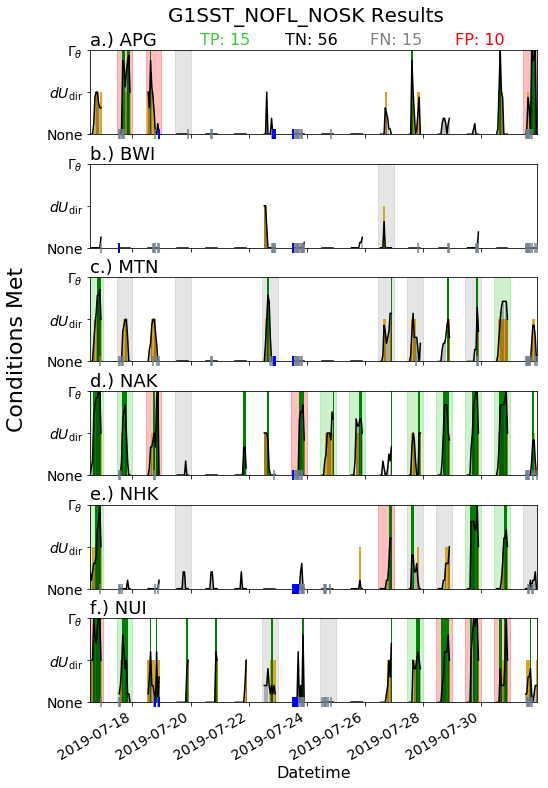

G1SST_NOFL_SKNT


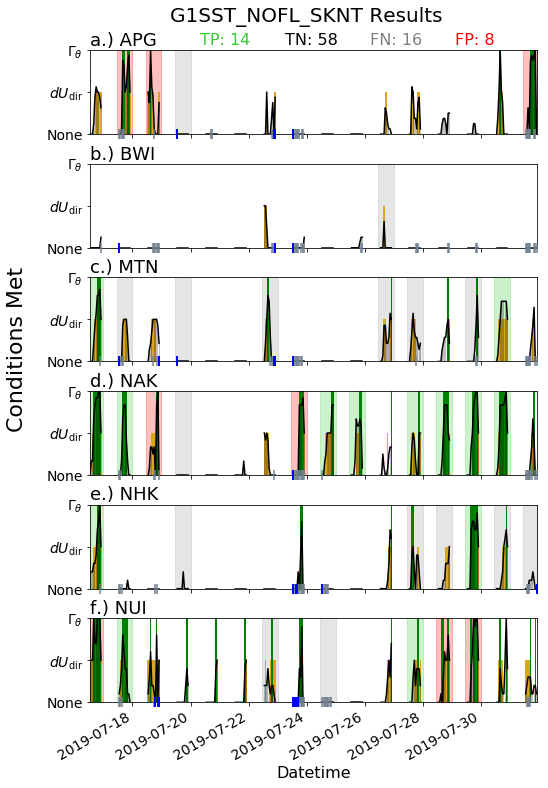

G1SST_FILL_NOSK


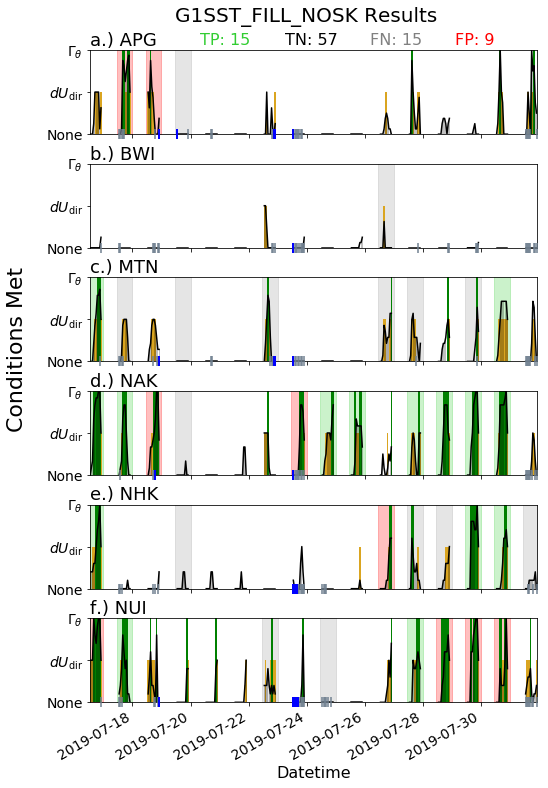

G1SST_FILL_SKNT


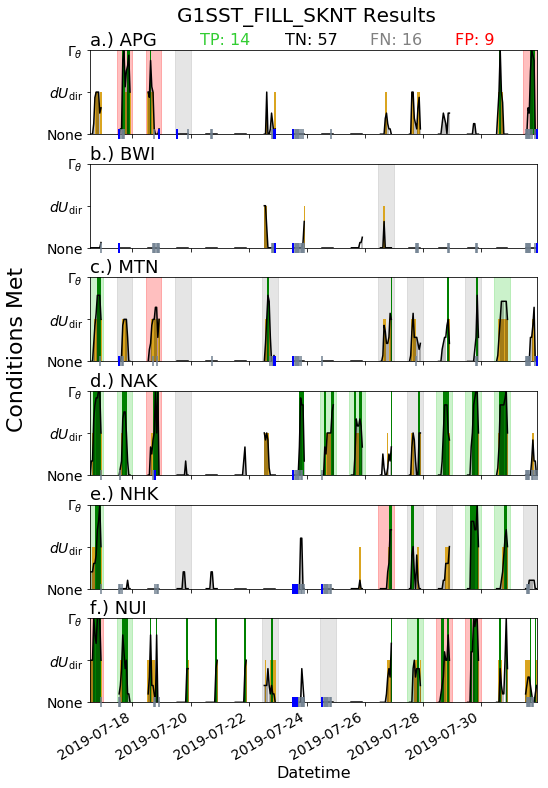

MUR1K_NOFL_NOSK


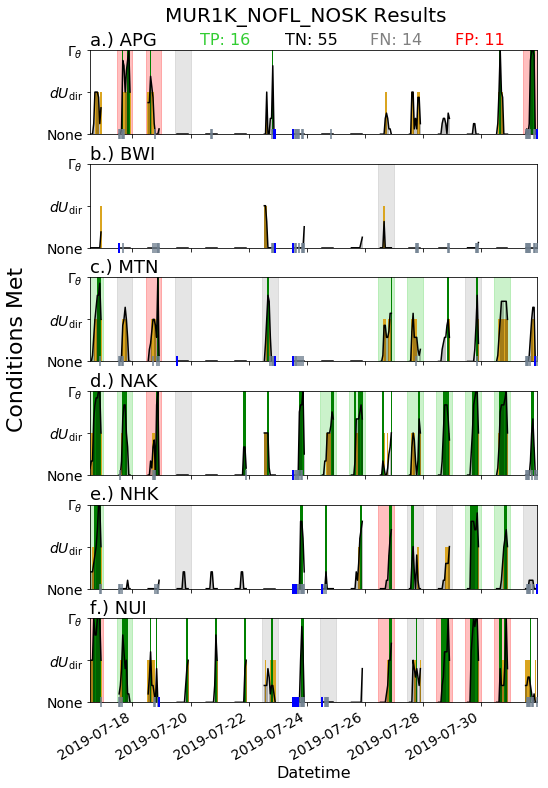

MUR1K_NOFL_SKNT


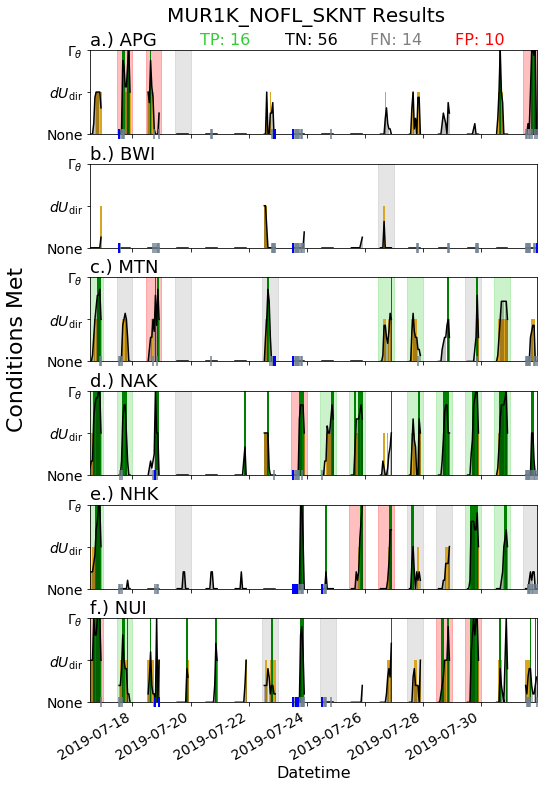

MUR1K_FILL_NOSK


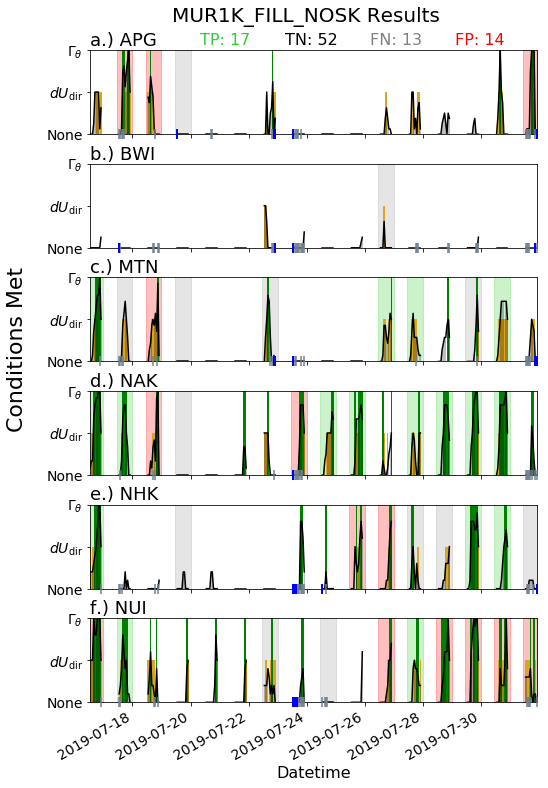

MUR1K_FILL_SKNT


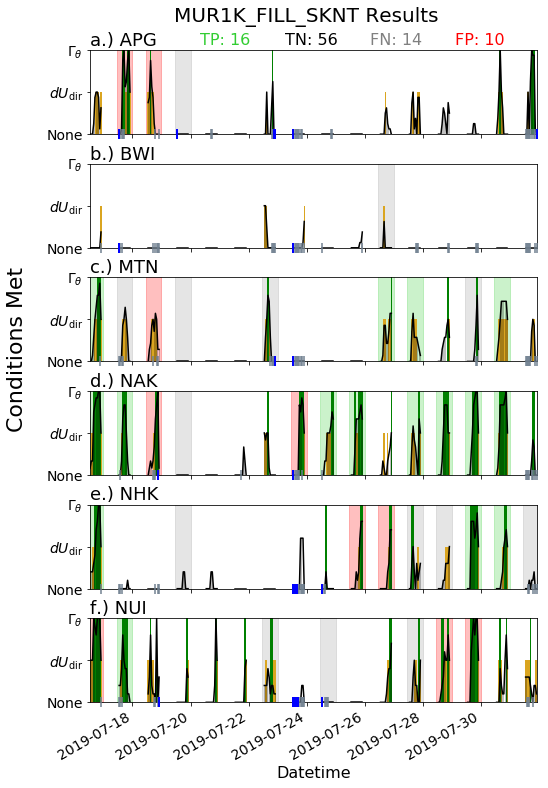

MODIS_NOFL_NOSK


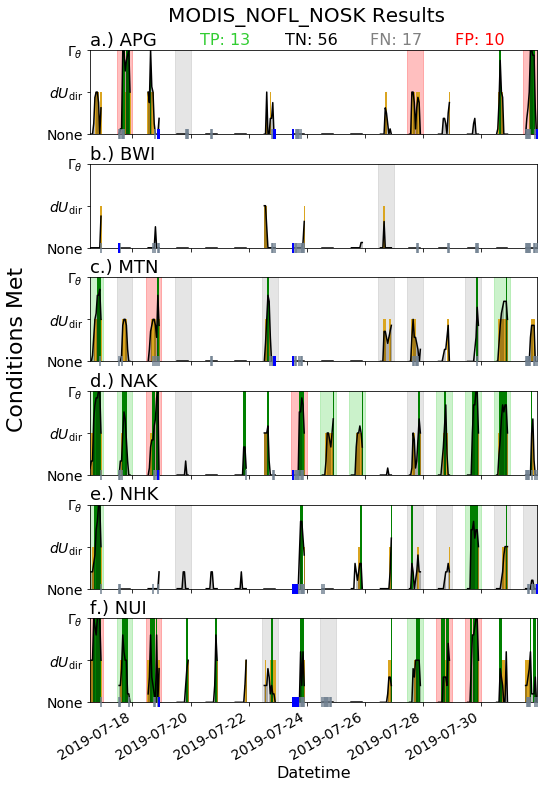

MODIS_NOFL_SKNT


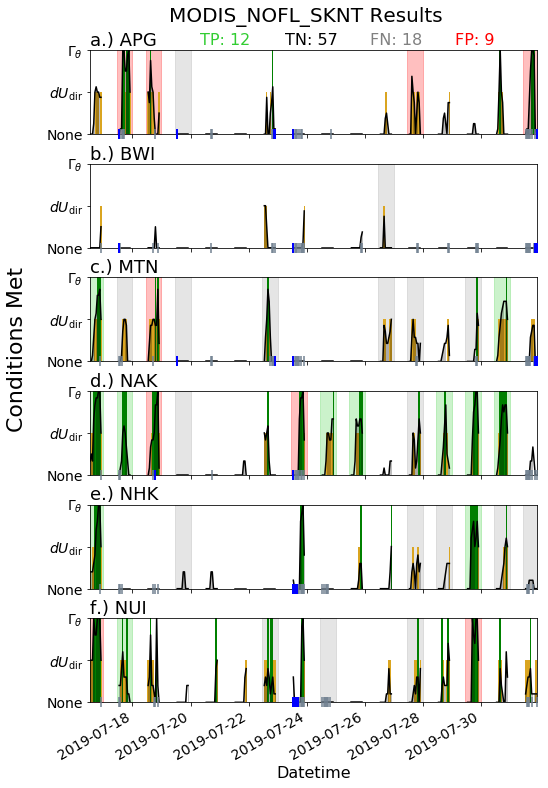

MODIS_FILL_NOSK


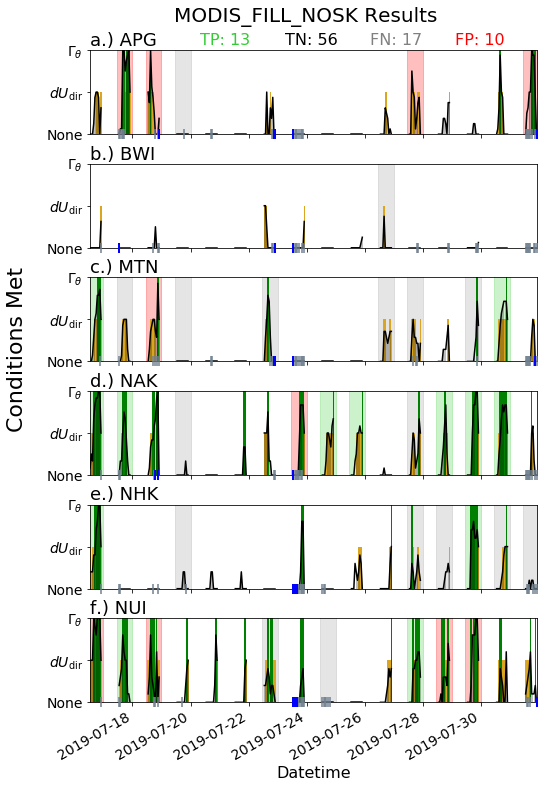

MODIS_FILL_SKNT


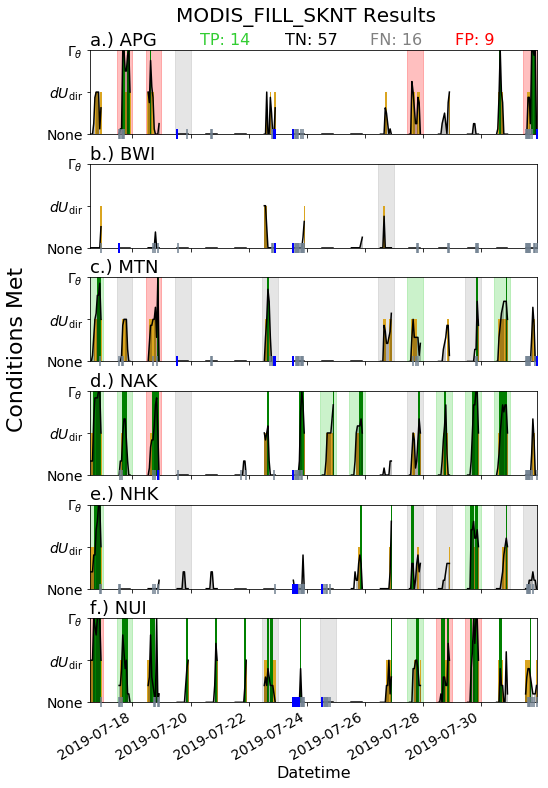

OSPOG_NOFL_NOSK


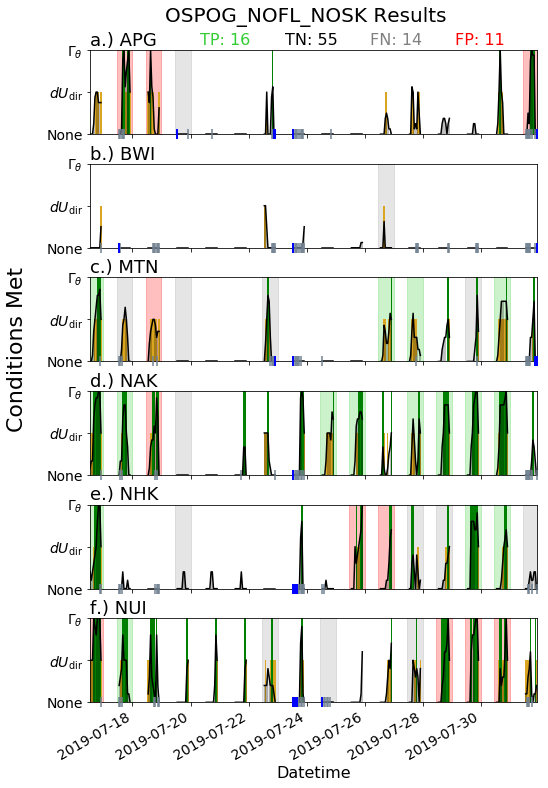

OSPOG_NOFL_SKNT


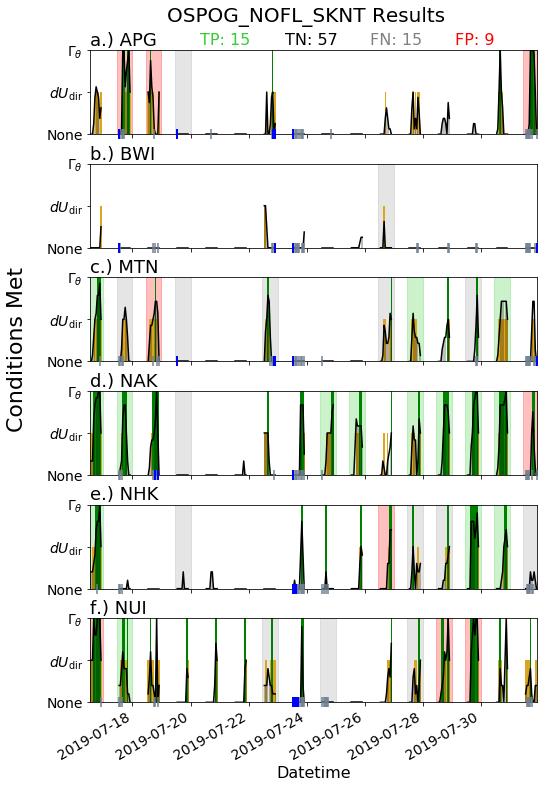

OSPOG_FILL_NOSK


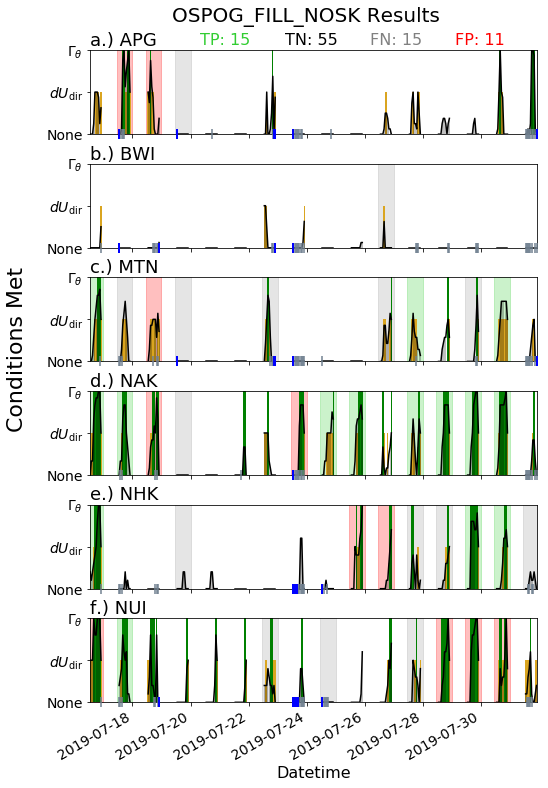

OSPOG_FILL_SKNT


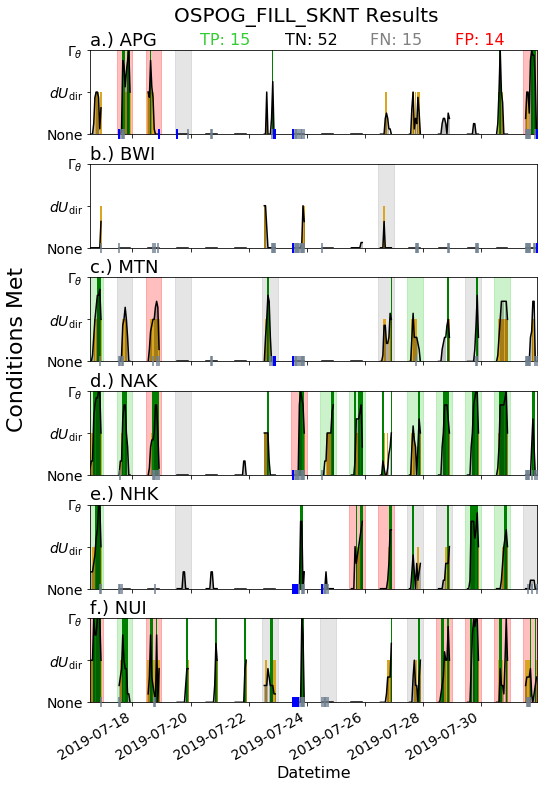

OSTIA_NOFL_NOSK


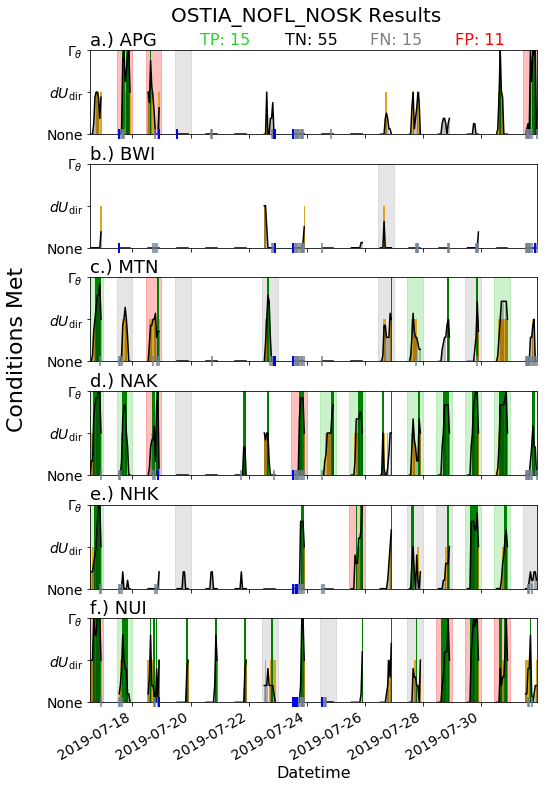

OSTIA_NOFL_SKNT


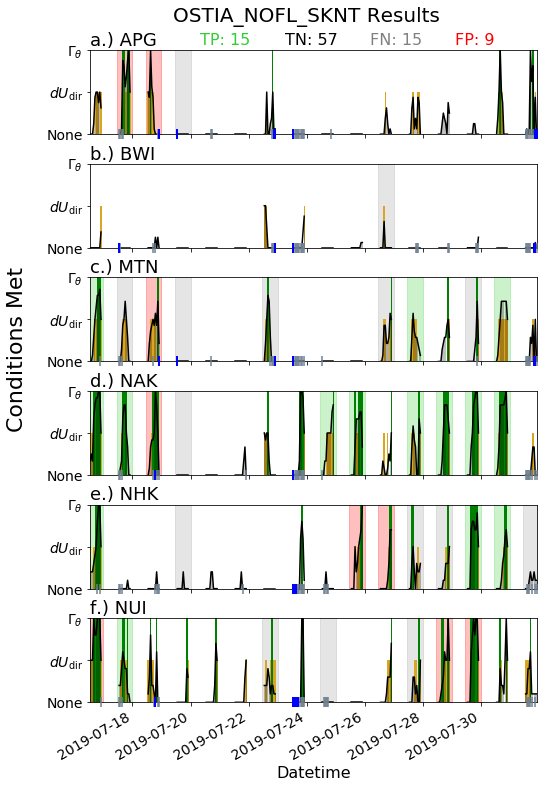

OSTIA_FILL_NOSK


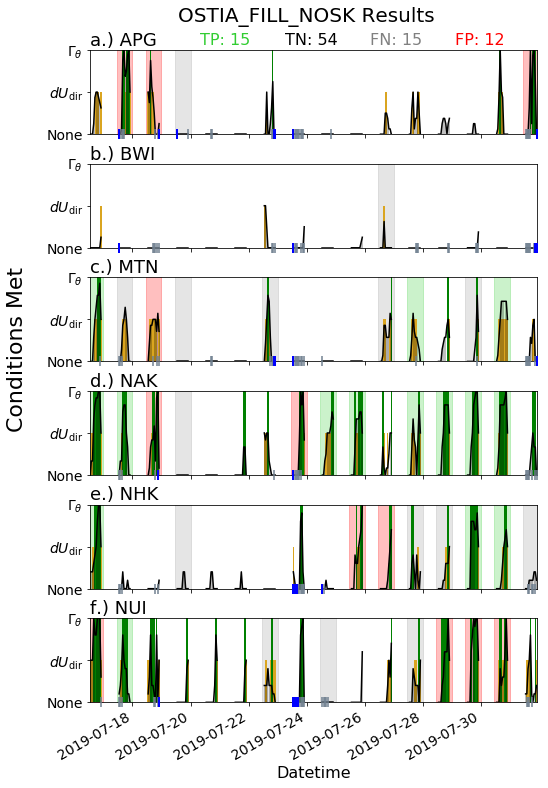

OSTIA_FILL_SKNT


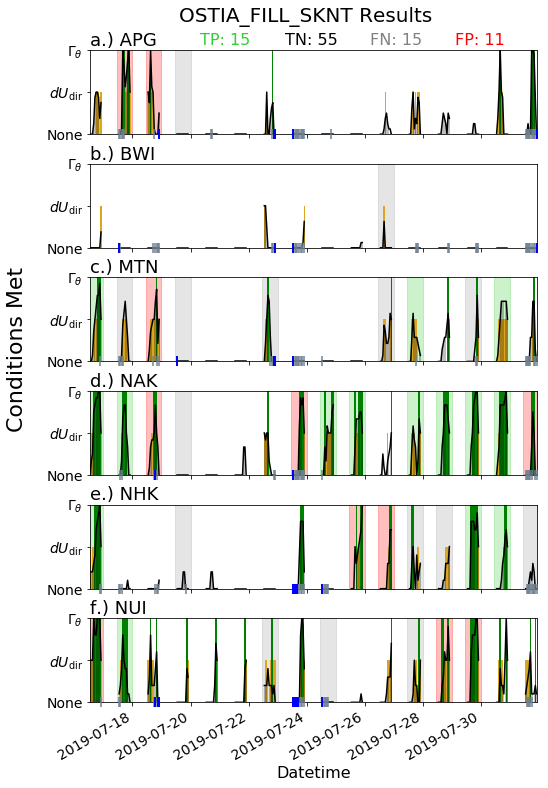

NAVOK_NOFL_NOSK


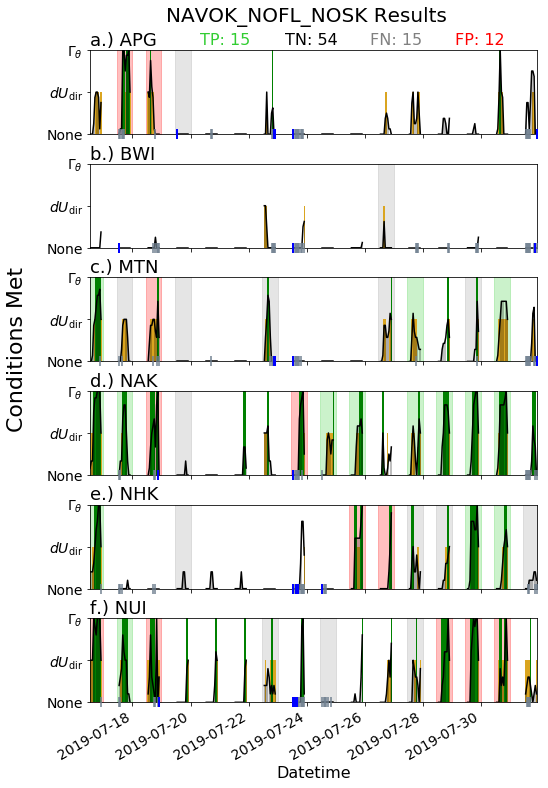

NAVOK_NOFL_SKNT


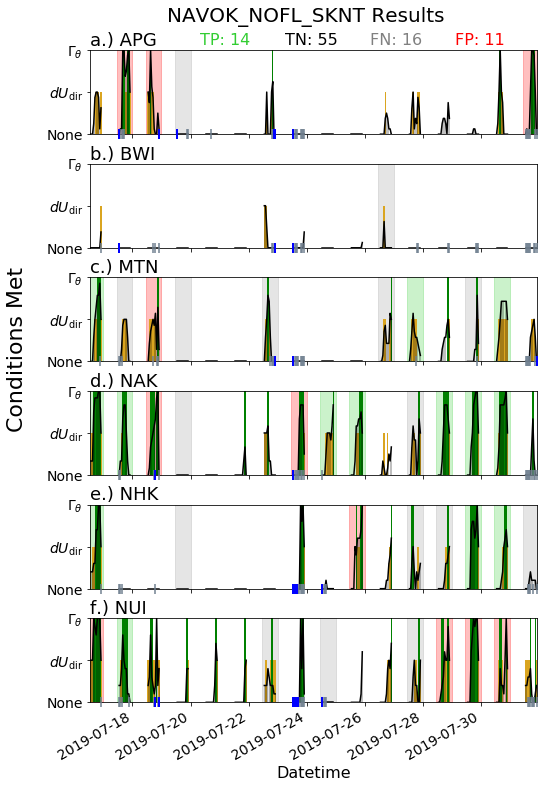

NAVOK_FILL_NOSK


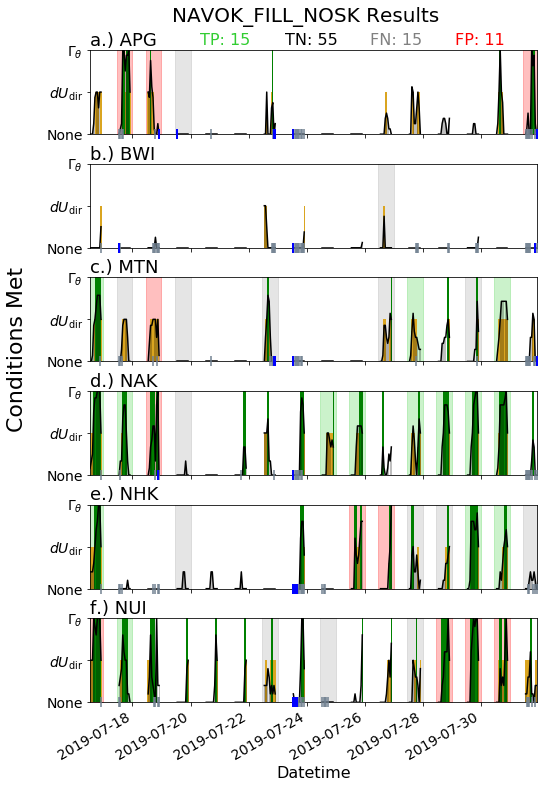

NAVOK_FILL_SKNT


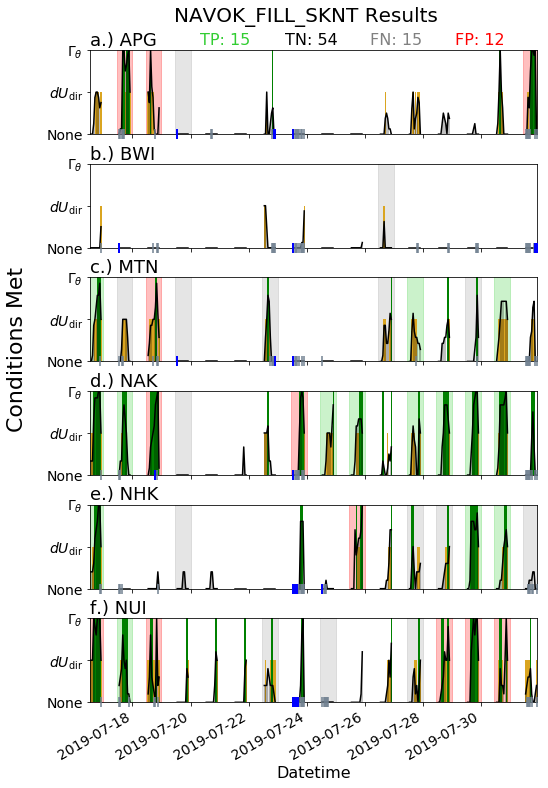

CMC01_NOFL_NOSK


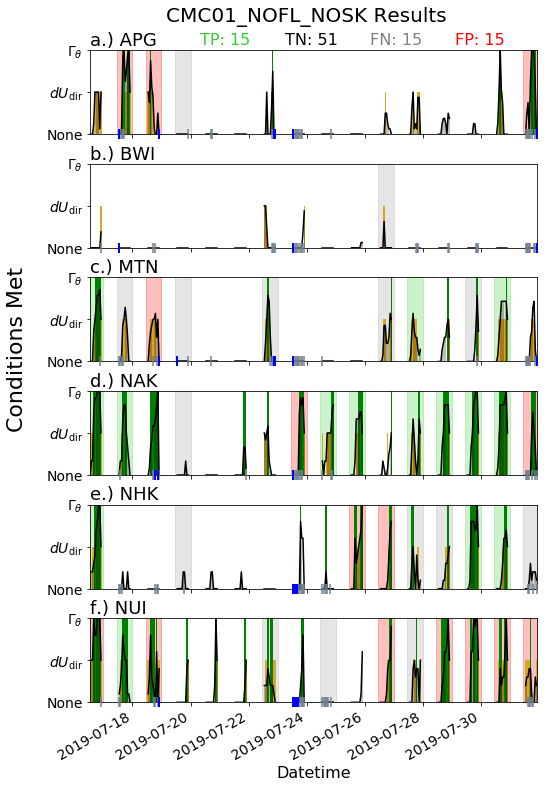

CMC01_NOFL_SKNT


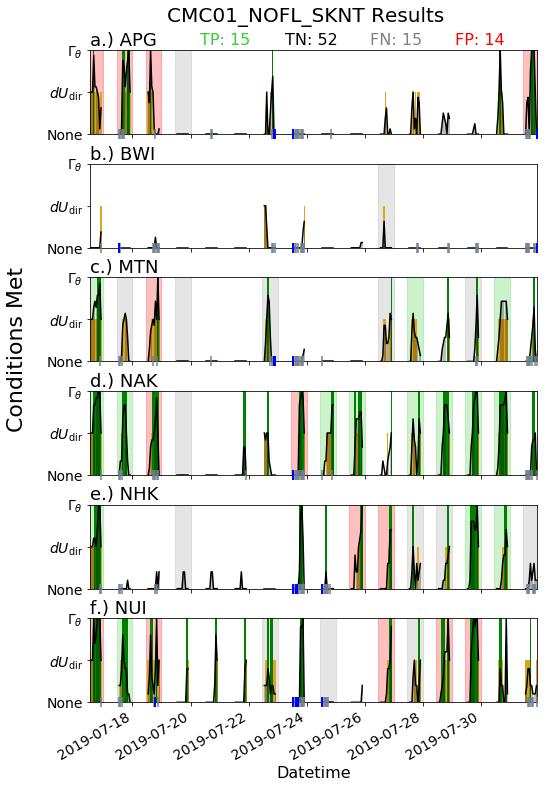

CMC01_FILL_NOSK


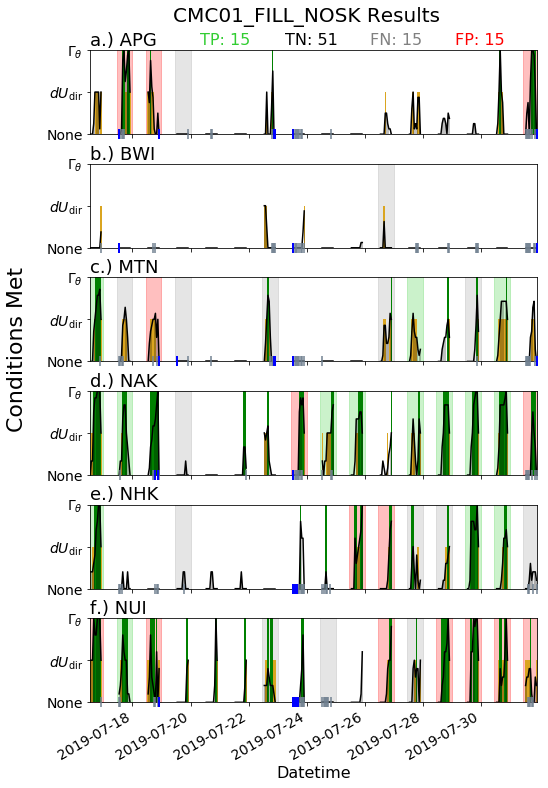

CMC01_FILL_SKNT


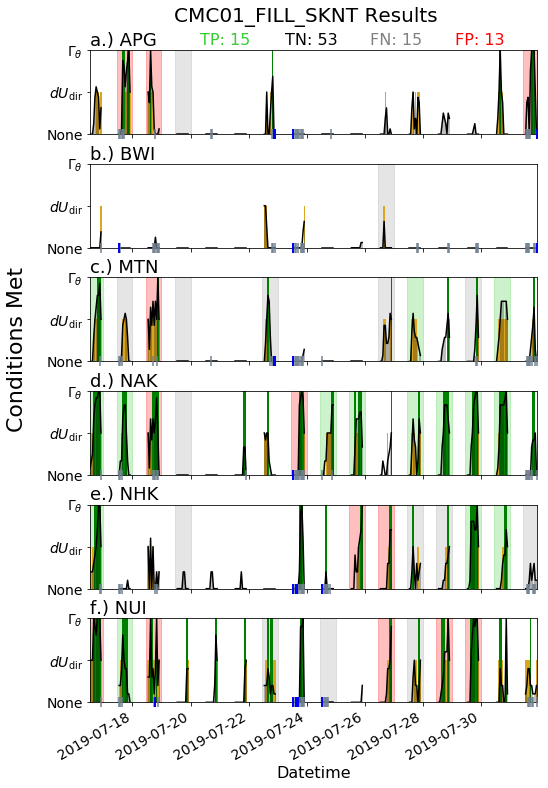

NCEIA_NOFL_NOSK


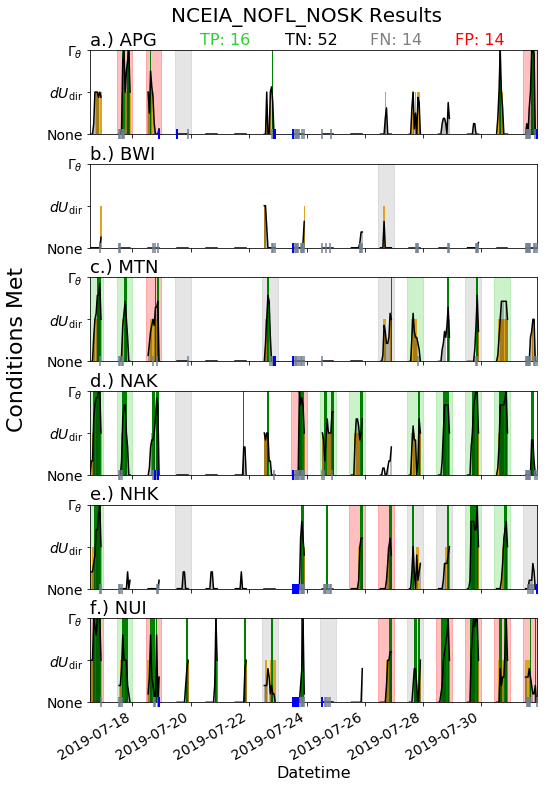

NCEIA_NOFL_SKNT


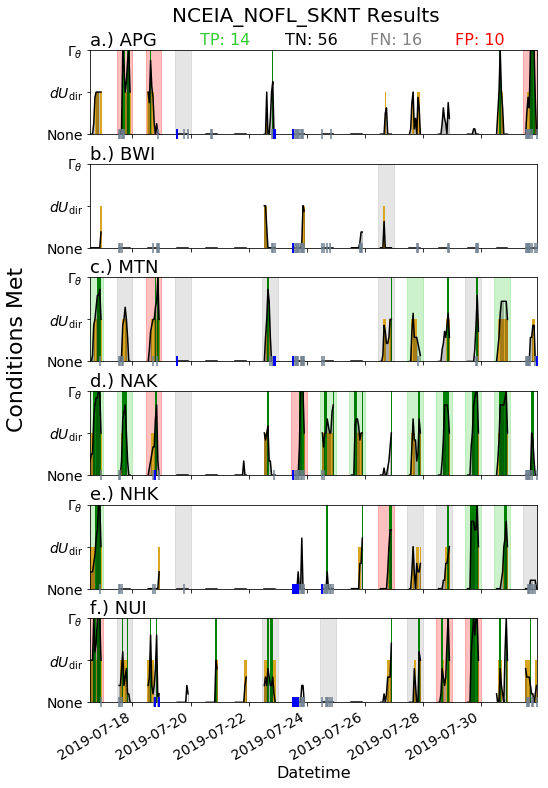

NCEIA_FILL_NOSK


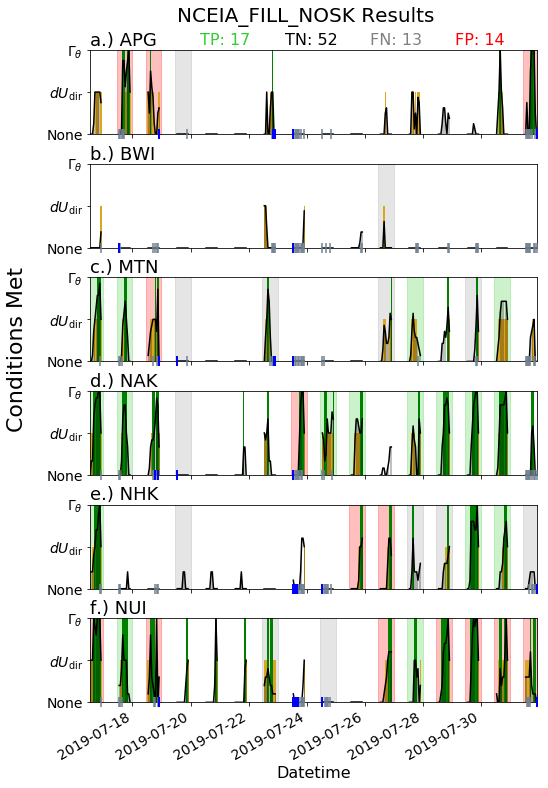

NCEIA_FILL_SKNT


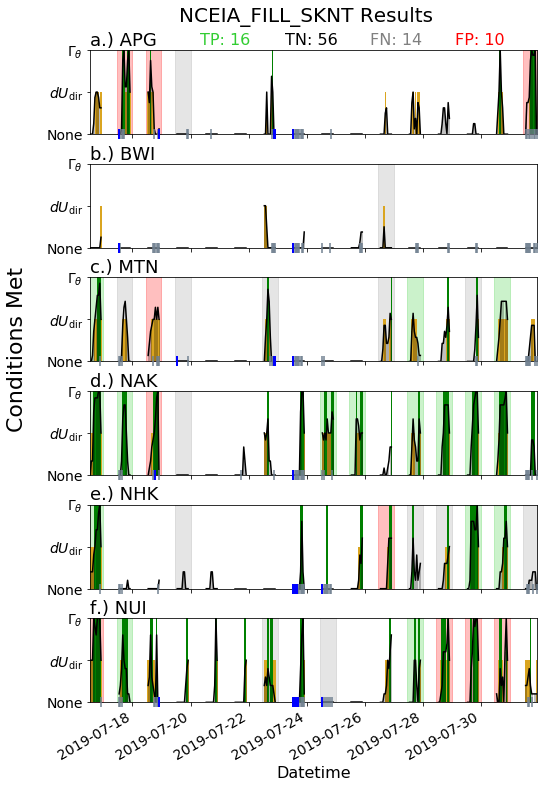

In [13]:
check_rain_and_clouds = True
use_neighbors = True

verbose = False

show_plot = False

use_all_days = True

show_close = False

period_start = pd.to_datetime('2019-07-16 00:00:00')
period_end   = breeze_ds_f.datetime.data[-1]

cMatrix_color_dict = {'TP':'limegreen',
                      'FP':'red',
                      'FN':'grey',
                   'close':'darkorange',
                      'TN':'k'}

confusion_matrix_dict = {}
simulated_bb_days_dict = {}

bb_observed_dates_list = bb_observed_dates['NumericalMinMax']
all_observed_dates_f = all_observed_dates['NumericalMinMax']

#for cc,case in enumerate(cases_for_numerical):
for cc,case in enumerate(cases):
    breeze_ds_f = breeze_ds_dict[case]
    cMatrix_dict = {'TP':0,
                    'TN':0,
                    'FP':0,
                    'FN':0,
                 'close':0}
    cMatrix_simulated_days = {'date':[],'result':[],'station':[]}
    print(case)
    fig,ax = plt.subplots(nrows=len(near_shore_stations),figsize=(8,12),sharex=True)
    fig.subplots_adjust(hspace=0.35)
    for ss,stn in enumerate(near_shore_stations):

        if 'HRRR' in case:
            if case == 'HRRRf': 
                hrrri,hrrrj = 'hrrrfi','hrrrfj'
            if case == 'HRRRa': 
                hrrri,hrrrj = 'hrrrai','hrrraj'                
            stn_bb_ds = breeze_ds_f.sel(ygrid_0=stn_dict[stn][hrrrj],xgrid_0=stn_dict[stn][hrrri],
                                        datetime=slice(period_start,period_end))
            stn_color = stn_bb_ds.breeze
            stn_cloud = stn_bb_ds.is_cloudy
            stn_rain  = stn_bb_ds.is_raining
            surrounding_points = breeze_ds_f.breeze.sel(ygrid_0=slice(stn_dict[stn][hrrrj]-1,stn_dict[stn][hrrrj]+2),
                                                        xgrid_0=slice(stn_dict[stn][hrrri]-1,stn_dict[stn][hrrri]+2)).copy()
            surrounding_points.sel(xgrid_0=1,ygrid_0=1).data[:] = surrounding_points.sel(
                                                                        xgrid_0=1,ygrid_0=1).data[:]*np.nan
            avg_neighbors = surrounding_points.mean(dim=['ygrid_0','xgrid_0'])
        else:
            stn_bb_ds = breeze_ds_f.sel(south_north=stn_dict[stn]['j'],west_east=stn_dict[stn]['i'],
                                        datetime=slice(period_start,period_end))
            
            stn_color = stn_bb_ds.breeze
            stn_cloud = stn_bb_ds.is_cloudy
            stn_rain  = stn_bb_ds.is_raining
            surrounding_points = breeze_ds_f.breeze.sel(south_north=slice(stn_dict[stn]['j']-1,stn_dict[stn]['j']+2),
                                                   west_east=slice(stn_dict[stn]['i']-1,stn_dict[stn]['i']+2)).copy()
            surrounding_points.sel(west_east=1,south_north=1).data[:] = surrounding_points.sel(
                                                                        west_east=1,south_north=1).data[:]*np.nan
            avg_neighbors = surrounding_points.mean(dim=['south_north','west_east'])
        if use_neighbors:
            #avg_neighbors.plot(marker='o',lw=1.0,c='k',label=stn,ax=ax[ss],alpha=0.5)
            ax[ss].bar(avg_neighbors.datetime.data,avg_neighbors.data,
                       width=pd.to_timedelta(45,'min'),color='k',alpha=0.25,zorder=10)            
        for pts in [1,2]:
            ax[ss].bar(stn_color.datetime.data[stn_color==pts],stn_color.data[stn_color==pts],
                       #width=pd.to_timedelta(30,'min'),color=breeze_cmap[pts])
                       width=0.05,color=breeze_cmap[pts])
        
#        stn_color.plot(lw=2.0,c='k',ax=ax[ss])
#        zro_pts = stn_color.where(stn_color==0.0)
#        one_pts = stn_color.where(stn_color==1.0)
#        two_pts = stn_color.where(stn_color==2.0)
#        zro_pts.plot(marker='o',lw=0.0,c=breeze_cmap[0],ax=ax[ss],markersize=10.0)
#        one_pts.plot(marker='o',lw=0.0,c=breeze_cmap[1],ax=ax[ss],markersize=10.0)
#        two_pts.plot(marker='o',lw=0.0,c=breeze_cmap[2],ax=ax[ss],markersize=10.0)
        #stn_color.plot(marker='o',lw=0.0,c=breeze_cmap[2],ax=ax[ss])
        if check_rain_and_clouds:
            cld_plot = stn_cloud.where(stn_cloud==1.0)
            pcp_plot = stn_rain.where(stn_rain==1.0)
            (cld_plot-1).plot(marker='|',markersize=10,lw=0.0,c='slategray',label=stn,ax=ax[ss],clip_on=False,zorder=15,mew=1.5)
            (pcp_plot-1).plot(marker='|',markersize=10,lw=0.0,c='blue',label=stn,ax=ax[ss],clip_on=False,zorder=16,mew=2.0)

        ax[ss].tick_params(labelsize=14)
        if ss == 3:
            ax[ss].set_ylabel('Conditions Met',size=22,y=1.5,labelpad=19.4)
        else:
            ax[ss].set_ylabel('',size=16)            
        ax[ss].set_title('')
        ax[ss].set_xlabel('',size=16)
        ax[ss].text(stn_color.datetime.data[0],2.01,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',size=18)#,color=stn_colors[ss])
        ax[ss].set_yticklabels(['None','$dU_{\mathrm{dir}}$',r'$\Gamma_{\theta}$'])
        ax[ss].set_ylim(0,2.0)
        plt.xticks(pd.date_range(start=period_start, end=period_end+pd.to_timedelta(2,'d'), 
                                 freq=pd.to_timedelta(2,'d')),
                   rotation=30,ha='right')
        for dd,day in enumerate(pd.date_range(start=period_start, end=period_end)):
            
            day_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
            fill_color = None
            if use_all_days:
                observed_days = all_observed_dates_f.copy()
                
                if day_str in list(observed_days.keys()): # If model detects a breeze, what fill color will it be?
                    if stn in observed_days[day_str]: # Station is observed AND simulated
                        fill_color = cMatrix_color_dict['TP']
                    else:
                        #print(day,stn,observed_days[day_str]) # Day had BB but station didn't observe it
                        if show_close:
                            fill_color = cMatrix_color_dict['close']
                        else:
                            fill_color = cMatrix_color_dict['FP']
                else:
                    fill_color = cMatrix_color_dict['FP'] # No observed BBs on this day
                
            else: # Only using ST currently... need to figure this out if going to use.
                observed_days = bb_observed_dates_list[method].copy()
            
                for mm,method in enumerate(list(bb_observed_dates_list.keys())[:1]):
                    if day_str in list(observed_days.keys()):
                        if stn in observed_days[day_str]:
                            fill_color = 'green'
                        else:
                            fill_color = 'yellow'
                    else:
                        fill_color = 'red'


            bb_day    = stn_color.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            cloud_day = stn_cloud.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            rain_day  = stn_rain.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            neighbor_day = avg_neighbors.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            
            if use_neighbors:
                #avg_neighbors.plot(marker='o',lw=1.0,c='k',label=stn,ax=ax[ss],alpha=0.5)
                neighbor_plt = neighbor_day.sel(datetime=slice(day+pd.to_timedelta(13,'h'),day+pd.to_timedelta(22,'h')))
                ax[ss].plot(neighbor_plt.datetime.data,neighbor_plt.data,
                            color='k',alpha=1.0,zorder=10)             
            
            bb_day_dict = {'bb_day':bb_day,
                     'neighbor_day':neighbor_day,
                        'cloud_day':cloud_day,
                         'rain_day':rain_day}
                
            bb_detected = validate_bay_breeze(bb_day_dict,
                                              use_neighbors=use_neighbors,
                                              check_rain_clouds=check_rain_and_clouds,
                                              detect_option=3,
                                              verbose=verbose)
            

            if bb_detected:
                ax[ss].fill_betweenx([0,4],bb_day.datetime.data[0]-pd.to_timedelta(2,'h'),
                                         bb_day.datetime.data[-1]+pd.to_timedelta(2,'h'),
                                     color=fill_color,alpha=0.25)
                if fill_color == cMatrix_color_dict['TP']:
                    cMatrix_dict['TP'] += 1
                    cMatrix_simulated_days['date'].append(day_str)
                    cMatrix_simulated_days['result'].append('TP')
                    cMatrix_simulated_days['station'].append(stn)
                elif fill_color == cMatrix_color_dict['FP']: # or fill_color == cMatrix_color_dict['close']:
                    cMatrix_dict['FP'] += 1
                    cMatrix_simulated_days['date'].append(day_str)
                    cMatrix_simulated_days['result'].append('FP')
                    cMatrix_simulated_days['station'].append(stn)
                elif fill_color == cMatrix_color_dict['close']:
                    cMatrix_dict['FP'] += 1
                    cMatrix_dict['close'] += 1

            else:
                if fill_color == cMatrix_color_dict['TP']:
                    fill_color = cMatrix_color_dict['FN']
                    cMatrix_dict['FN'] += 1
                    ax[ss].fill_betweenx([0,4],bb_day.datetime.data[0]-pd.to_timedelta(2,'h'),
                                         bb_day.datetime.data[-1]+pd.to_timedelta(2,'h'),
                                         color=fill_color,alpha=0.2)
                else:
                    cMatrix_dict['TN'] += 1
        
    ax[0].set_xlim(stn_color.datetime.data[0],stn_color.datetime.data[-1])
    ax[-1].set_xlabel('Datetime',size=16)
    
    cMatrix_list = ['TP','TN','FN','FP']
    for cm,cMatrix in enumerate(cMatrix_list):
        str_x = pd.to_datetime('2019-07-20 08:00:00') + pd.to_timedelta(cm*2.93,'d')
        cMatrix_str = '{}: {}'.format(cMatrix,cMatrix_dict[cMatrix])

        if cMatrix == 'FP':
            if show_close:
                a = [cMatrix_str,'({})'.format(cMatrix_dict['close'])]
                c = [cMatrix_color_dict[cMatrix],cMatrix_color_dict['close']]

                r = fig.canvas.get_renderer()
                space = pd.to_timedelta(2,'h')
                w = str_x
                counter = 0
                for i in a:
                    t = ax[0].text(w,2.05, a[counter],color=c[counter],fontsize=16,ha='left',va='bottom')
                    transf = ax[0].transData.inverted()
                    bb = t.get_window_extent(renderer=fig.canvas.renderer)
                    bb = bb.transformed(transf)
                    w += pd.to_timedelta(mpdates.num2date(bb.xmax)-mpdates.num2date(bb.xmin)) + space
                    counter = counter + 1
            else:
                cm_text = ax[0].text(str_x,2.05,cMatrix_str,ha='left',va='bottom',size=16,
                                     color=cMatrix_color_dict[cMatrix])                
        else:
            cm_text = ax[0].text(str_x,2.05,cMatrix_str,ha='left',va='bottom',size=16,
                                 color=cMatrix_color_dict[cMatrix])


            #cm_text.draw(fig.canvas.get_renderer())
            #txt_ex = cm_text.get_window_extent()
            #str_x = txt_ex.xmin + txt_ex.width
            #ax[0].text(str_x,2.05,'({})'.format(cMatrix_dict['close']),ha='right',va='bottom',size=16,
            #           color=cMatrix_color_dict['close'])
    case_str = case
    plt.suptitle('{} Results'.format(case_str),y=0.93,size=20)
    fig_name = '{}{}_MBDA_Results'.format(save_dir,case_str.replace('-','').replace(' ',''))

    if show_close: fig_name += '_close'
    if save_figs: 
        plt.savefig('{}.png'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
        plt.savefig('{}.pdf'.format(fig_name), bbox_inches = 'tight',pad_inches = 0.1)
    plt.show()
    
    confusion_matrix_dict[case] = {'MBDA':cMatrix_dict}
    simulated_bb_days_dict[case] = {'MBDA':cMatrix_simulated_days}
    

# Example day:

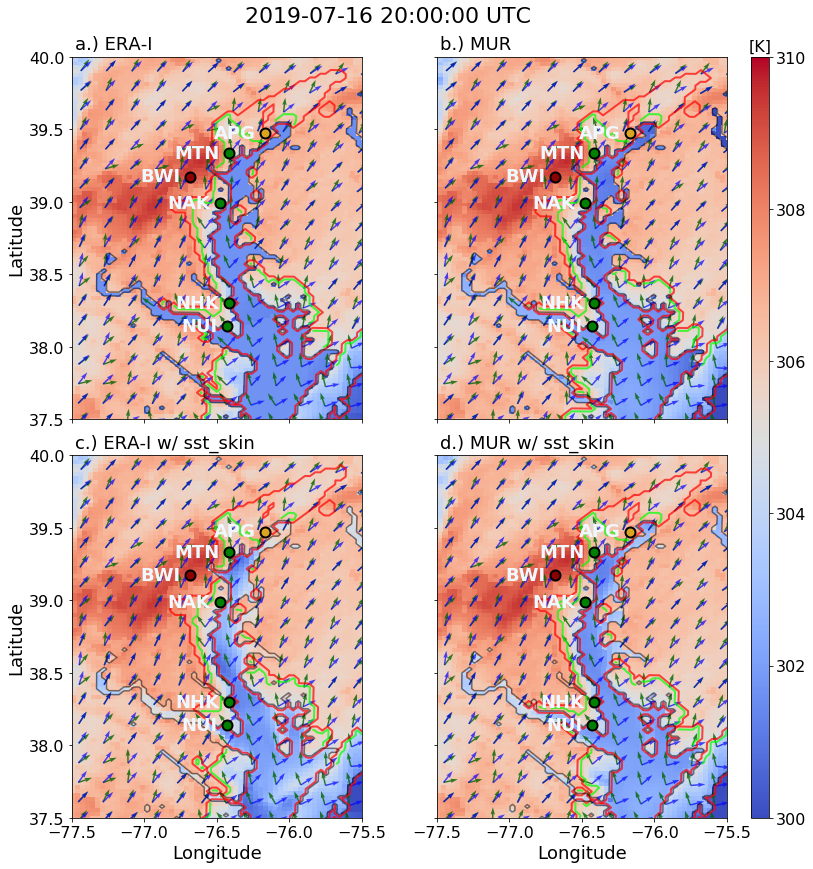

In [14]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(12,14),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.1)

time_for_plot = '2019-07-30 18:00:00'
wrf_rst_ind = -1
time_for_plot = '2019-07-16 20:00:00'
wrf_rst_ind = 0

color_stn_by = 'value' # value or confusion


wrfout_dir = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/'

cases_for_example = []
case_type = ['NOFL_NOSK','NOFL_SKNT']
case_base = ['DEFLT','MUR1K']
for case in cases:
    if case.split('_')[0] in case_base:
        if '_'.join(case.split('_')[1:]) in case_type:
            cases_for_example.append(case)
            
row,col = 0,0
count = 0
for cc,case in enumerate(cases_for_example):
    #ax[col,row].text(0.01,1.01,'{}.)'.format(ascii_lowercase[count]),
    #                 size=18,transform=ax[col,row].transAxes,va='bottom')
    breeze_ds_f = breeze_ds_dict[case]
    case_plt_dict = case_dict[case]['d03']
    if cc == 0:
        lat_c = breeze_ds_f.XLAT
        lon_c = breeze_ds_f.XLONG
        lat_s = 0.5*(lat_c[1:,1:] + lat_c[:-1,:-1])
        lon_s = 0.5*(lon_c[1:,1:] + lon_c[:-1,:-1])
    
    mbda_result = simulated_bb_days_dict[case]['MBDA']
    mbda_dates = np.asarray(mbda_result['date'])
    good_inds = np.where(mbda_dates == str(time_for_plot.split(' ')[0]))[0]
    mbda_bb_results = np.asarray(mbda_result['result'])[good_inds]
    mbda_bb_stns = np.asarray(mbda_result['station'])[good_inds]

    wrfout_files = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrfout_dir,case,restarts[wrf_rst_ind],case_dom[0])))[12:]
    for ff in wrfout_files: 
        if time_for_plot.replace(' ','_') in ff: wrfout_f = ff
        
    wrfout = xr.open_dataset(wrfout_f,decode_times=False).sel(Time=0)
    
    # Surface Plot:
    plt_sfc = wrfout.T2.copy()
    plt_sfc = plt_sfc.where(wrfout.LANDMASK==1.0).fillna(0.0)
    plt_sfc += wrfout.TSK.where(wrfout.LANDMASK==0.0).fillna(0.0)
    sfc_plt = ax[col,row].pcolormesh(lon_s,lat_s,plt_sfc[1:-1,1:-1],
                                     norm=Normalize(300,310),
                                     cmap=plt.cm.coolwarm,
                                     rasterized=True)

    # Wind quivers
    u10 = wrfout.U10
    v10 = wrfout.V10
    vel10 = (u10**2 + v10**2)**0.5
    u10_norm = u10/vel10
    v10_norm = v10/vel10
    z = (((wrfout.PH+wrfout.PHB)/9.81)-wrfout.HGT).mean(dim=['south_north','west_east'])
    km_ind = np.where(z>=1000.0)[0][0]
    u1k = wrfout.U.sel(bottom_top=km_ind)
    u1k = 0.5*(u1k[:,1:]+u1k[:,:-1])
    u1k = u1k.rename({'west_east_stag':'west_east'})
    v1k = wrfout.V.sel(bottom_top=km_ind)
    v1k = 0.5*(v1k[1:,:]+v1k[:-1,:])
    v1k = v1k.rename({'south_north_stag':'south_north'})

    vel1k = (u1k**2 + v1k**2)**0.5
    u1k_norm = u1k/vel1k
    v1k_norm = v1k/vel1k
    q_int = 5
    q_s = 4
    ax[col,row].quiver(lon_c[q_s::q_int,q_s::q_int],lat_c[q_s::q_int,q_s::q_int],
                       u10_norm[q_s::q_int,q_s::q_int],v10_norm[q_s::q_int,q_s::q_int],
                       scale=20.0,width=5.0e-3,alpha=0.8,color='darkgreen')
    ax[col,row].quiver(lon_c[q_s::q_int,q_s::q_int],lat_c[q_s::q_int,q_s::q_int],
                       u1k_norm[q_s::q_int,q_s::q_int],v1k_norm[q_s::q_int,q_s::q_int],
                       scale=20.0,width=5.0e-3,color='b',alpha=0.7)
    

    
    toi_ds = breeze_ds_f.sel(datetime=time_for_plot)
    #ax[col,row].pcolormesh(lon_s,lat_s,toi_ds.breeze[1:-1,1:-1])
    ax[col,row].contour(lon_c,lat_c,toi_ds.good_wdir,levels=[0.5],colors='red',linewidths=2.0,alpha=0.7)
    ax[col,row].contour(lon_c,lat_c,toi_ds.breeze,levels=[1.5],colors='lime',linewidths=2.0,alpha=0.7)

    ax[col,row].contour(lon_c,lat_c,toi_ds.land_mask,colors='k',levels=[0.5],alpha=0.5)
    
    for ss,stn in enumerate(near_shore_stations):
        
        if color_stn_by == 'confusion':
            if stn in mbda_bb_stns:
                if mbda_bb_results[np.where(mbda_bb_stns == stn)] == 'TP':
                    m_c = 'g'
                else:
                    m_c = 'r'
            else:
                m_c = 'k'
        elif color_stn_by == 'value':
            
            val = int(toi_ds.breeze.sel(south_north=stn_dict[stn]['j'],west_east=stn_dict[stn]['i']))
            m_c = breeze_cmap[val]

        ax[col,row].scatter(obs_res_full.sel(station=stn).lon.data,obs_res_full.sel(station=stn).lat.data,
                            c=m_c,s=100,zorder=100,marker='o',ec='k',lw=2.0)
        if (stn == 'NAK') or (stn == 'NUI'):
            txt_y_adj = -0.0
        else:
            txt_y_adj = 0.0
        ax[col,row].text(obs_res_full.sel(station=stn).lon.data-0.065,
                         obs_res_full.sel(station=stn).lat.data+txt_y_adj,
                         stn,
                         c='aliceblue',ha='right',va='center',size=18,zorder=100,weight="bold")
#    ax[col,row].set_title(case_plt_dict['name'],size=22)

    leg_labels = ['Default','sst_skin','Filled','Fill + skin']

    cname = case_plt_dict['name']
    if '_SKNT' in cname:
        cname = cname.replace('_SKNT',' w/ sst_skin')
    ax[col,row].text(0.01,1.01,'{}.) {}'.format(ascii_lowercase[col*2 + row],cname),
                     size=18,transform=ax[col,row].transAxes,va='bottom')
    col += 1
    count += 1
    if col >= 2:
        col = 0
        row += 1
        
for row in range(0,2):
    for col in range(0,2):
        ax[row,col].tick_params(labelsize=16)
        ax[row,col].set_xlim(-77.5,-75.5)
        ax[row,col].set_ylim(37.5,40)
        ax[row,col].set_aspect('equal')
        if col == 0: ax[row,col].set_ylabel('Latitude',size=18)
        if row == 1: ax[row,col].set_xlabel('Longitude',size=18)
        #ax[row,col].text(0.01,0.98,'{}.)'.format(ascii_lowercase[row*2 + col]),
        #                 size=18,transform=ax[row,col].transAxes,va='top')

cax  = fig.add_axes([0.92,0.125,0.02,0.755])
cbar = plt.colorbar(sfc_plt,cax=cax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title('[K]',size=16)

plt.suptitle(time_for_plot + ' UTC',size=22,y=0.93)

if save_figs:
    plt_str = 'MBDA_Example'
    if show_close: plt_str += '_close'
    plt.savefig('{}{}.png'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}{}.pdf'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Skill metrics:

In [15]:
def compute_skill_metrics(cf_dict,rmv_close=False):
    for case in cf_dict:
        for mm,meth in enumerate(cf_dict[case]):
            TP = cf_dict[case][meth]['TP']
            TN = cf_dict[case][meth]['TN']
            FP = cf_dict[case][meth]['FP']
            if rmv_close: 
                TP += cf_dict[case][meth]['close']
                FP -= cf_dict[case][meth]['close']
            FN = cf_dict[case][meth]['FN']
            recall    = TP/(TP+FN)
            try:
                precision = TP/(TP+FP)
            except:
                precision = 0.0
            if precision+recall > 0.0:
                F1 = 2.0*((precision*recall)/(precision+recall))
            else:
                F1 = 0.0
            try:
                FAR = FP/(FP+TP)
            except:
                FAR = 0.0
            CSI = TP/(TP+FN+FP)
            acc = (TP+TN)/(TP+TN+FP+FN)
            mcc = ((TP*TN) - (FP*FN))/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
            inform = recall + (TN/(TN+FP)) - 1
            mk  = precision + (TN/(TN+FN)) - 1 
            pct_of_events = (TP+FN)/(TN+FP)

            cf_dict[case][meth]['recall']    = recall    # 0 to 1 (good)
            cf_dict[case][meth]['precision'] = precision # 0 to 1 (good)
            cf_dict[case][meth]['F1']        = F1        # 0 to 1 (good)
            cf_dict[case][meth]['FAR']       = FAR       # 0 (good) to 1
            cf_dict[case][meth]['CSI']       = CSI       # 0 to 1 (good)
            cf_dict[case][meth]['Accuracy']  = acc       # 0 to 1 (good)
            cf_dict[case][meth]['MCC']       = mcc
            cf_dict[case][meth]['IF']        = inform    # varies between -1 and 1
            cf_dict[case][meth]['MK']        = mk        # varies between -1 and 1
            cf_dict[case][meth]['pct']       = pct_of_events

            print(case,meth,cf_dict[case][meth]['pct'])
    return(cf_dict)


In [16]:
confusion_matrix_dict = compute_skill_metrics(confusion_matrix_dict)

DEFLT_NOFL_NOSK MBDA 0.45454545454545453
DEFLT_NOFL_SKNT MBDA 0.45454545454545453
DEFLT_FILL_NOSK MBDA 0.45454545454545453
DEFLT_FILL_SKNT MBDA 0.45454545454545453
G1SST_NOFL_NOSK MBDA 0.45454545454545453
G1SST_NOFL_SKNT MBDA 0.45454545454545453
G1SST_FILL_NOSK MBDA 0.45454545454545453
G1SST_FILL_SKNT MBDA 0.45454545454545453
MUR1K_NOFL_NOSK MBDA 0.45454545454545453
MUR1K_NOFL_SKNT MBDA 0.45454545454545453
MUR1K_FILL_NOSK MBDA 0.45454545454545453
MUR1K_FILL_SKNT MBDA 0.45454545454545453
MODIS_NOFL_NOSK MBDA 0.45454545454545453
MODIS_NOFL_SKNT MBDA 0.45454545454545453
MODIS_FILL_NOSK MBDA 0.45454545454545453
MODIS_FILL_SKNT MBDA 0.45454545454545453
OSPOG_NOFL_NOSK MBDA 0.45454545454545453
OSPOG_NOFL_SKNT MBDA 0.45454545454545453
OSPOG_FILL_NOSK MBDA 0.45454545454545453
OSPOG_FILL_SKNT MBDA 0.45454545454545453
OSTIA_NOFL_NOSK MBDA 0.45454545454545453
OSTIA_NOFL_SKNT MBDA 0.45454545454545453
OSTIA_FILL_NOSK MBDA 0.45454545454545453
OSTIA_FILL_SKNT MBDA 0.45454545454545453
NAVOK_NOFL_NOSK 

In [17]:
metrics_for_table = ['TP','TN','FN','FP']#,'total','date']

compare_minmax = True

print(r'\begin{table}')
print(r'\begin{center}')
print(r'\caption{\label{table:ConfusionMatrix}}')
print(r'\bgroup')
print(r'\def\arraystretch{1.2}')
format_line = r'\begin{tabular}{|c|c|c|'
label_line = r'\textbf{WST} & \textbf{sst\_skin} & \textbf{Filled}'
for mm,metric in enumerate(metrics_for_table):
    if metric == 'TP':
        metric_str = 'Hit'
    elif metric == 'TN':
        metric_str = 'CR'
    elif metric == 'FP':
        metric_str = 'FA'
    elif metric == 'FN':
        metric_str = 'Miss'
    elif metric == 'total':
        metric_str = 'Total Breezes'
    elif metric == 'date':
        metric_str = 'Breeze Days'

    if compare_minmax:
        format_line += 'cc|'
        label_line += r' & \multicolumn{2}{c|}{\textbf{'+metric_str+r'}}'
    else:
        format_line += 'c|'
        label_line += r' & \textbf{'+metric_str+r'}'
        
format_line += r'}'
label_line += r'\\'
print(format_line)
print(r'\hline')
print(label_line)
print(r'\hline')
  
compare_close = False
cases_plot_order = cases.copy()
method = 'MBDA'
prev_case = str(cases_plot_order[0].split('_')[0])

mbda_bb_days = {}

for cc,case in enumerate(cases_plot_order):
    mbda_bb_days[case] = {'breezes': 0, 'days': 0}
    new_case = str(case.split('_')[0])
    if (cc == 0) or (new_case != prev_case):
        line = '\multirow{4}{*}{'+ case_dict[case]['d03']['name'] +'} &'
        prev_case = new_case
        if cc != 0: print(r'\hline')
    else:
        line = ' & '
    #case = case.replace('_d03','')
    if 'SKNT' in case:
        line += ' X &'
    else:
        line += ' & '
    if 'FILL' in case:
        line += ' X '
    else:
        line += '  '
    #line += '{} '.format(case_dict[case.replace('_d03','')]['d03']['name'].replace('_','\_'))
    for mm,metric in enumerate(metrics_for_table):

        val = confusion_matrix_dict[case][method][metric]
        line += '& \multicolumn{2}{c|}{'+'{0:d}'.format(val) + '} '
        if compare_close:
            line += ' & {0:d}'.format(confusion_matrix_dict_close[case][method][metric])
    line += r'\\'
    print(line)
    mbda_bb_days[case]['days'] = len(np.unique(simulated_bb_days_dict[case]['MBDA']['date']))
    mbda_bb_days[case]['breezes'] = confusion_matrix_dict[case][method]['TP'] + confusion_matrix_dict[case][method]['FP']
print(r'\hline')


print(r'\end{tabular}')
print(r'\egroup')
print(r'\end{center}')
print(r'\end{table}')

\begin{table}
\begin{center}
\caption{\label{table:ConfusionMatrix}}
\bgroup
\def\arraystretch{1.2}
\begin{tabular}{|c|c|c|cc|cc|cc|cc|}
\hline
\textbf{WST} & \textbf{sst\_skin} & \textbf{Filled} & \multicolumn{2}{c|}{\textbf{Hit}} & \multicolumn{2}{c|}{\textbf{CR}} & \multicolumn{2}{c|}{\textbf{Miss}} & \multicolumn{2}{c|}{\textbf{FA}}\\
\hline
\multirow{4}{*}{ERA-I} & &   & \multicolumn{2}{c|}{17} & \multicolumn{2}{c|}{51} & \multicolumn{2}{c|}{13} & \multicolumn{2}{c|}{15} \\
 &  X &  & \multicolumn{2}{c|}{15} & \multicolumn{2}{c|}{54} & \multicolumn{2}{c|}{15} & \multicolumn{2}{c|}{12} \\
 &  &  X & \multicolumn{2}{c|}{19} & \multicolumn{2}{c|}{47} & \multicolumn{2}{c|}{11} & \multicolumn{2}{c|}{19} \\
 &  X & X & \multicolumn{2}{c|}{17} & \multicolumn{2}{c|}{51} & \multicolumn{2}{c|}{13} & \multicolumn{2}{c|}{15} \\
\hline
\multirow{4}{*}{G1SST} & &   & \multicolumn{2}{c|}{15} & \multicolumn{2}{c|}{56} & \multicolumn{2}{c|}{15} & \multicolumn{2}{c|}{10} \\
 &  X &  & \multicolumn{

In [18]:
#metrics_for_table = ['CSI','Accuracy','FAR','MCC','MK']
metrics_for_table = ['CSI','Accuracy','MCC','MK','IF']
cases_plot_order = ['ERAI_YSU_CHRN_OST_NOSK_4DOM','ERA5_YSU_CHRN_ER5_NOSK_3DOM','GFSR_YSU_CHRN_GFS_NOSK_3DOM']

compare_minmax = True

print(r'\begin{table}')
print(r'\begin{center}')
print(r'\caption{\label{table:SkillMetrics}}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
format_line = r'\begin{tabular}{|c|c|'
label_line = r'\textbf{DA} & \textbf{Case}'
for mm,metric in enumerate(metrics_for_table):
    if compare_minmax:
        format_line += 'cc|'
        label_line += r' & \multicolumn{2}{c|}{\textbf{'+metric+r'}}'
    else:
        format_line += 'c|'
        label_line += r' & \textbf{'+metric+r'}'
format_line += r'}'
label_line += r'\\'
print(format_line)
print(r'\hline')
print(label_line)
print(r'\hline')
    
    
compare_close = False
cases_plot_order = cases.copy()
method = 'MBDA'
for cc,case in enumerate(cases_plot_order):
    if cc == 0:
        line = '\multirow{5}{*}{'+ method +'} &'
    else:
        line = ' & '
    #case = case.replace('_d03','')
    line += '{} '.format(case_dict[case.replace('_d03','')]['d03']['name'].replace('_','\_'))
    for mm,metric in enumerate(metrics_for_table):
        line += '& \multicolumn{2}{c|}{'+'{0:3.2f}'.format(confusion_matrix_dict[case][method][metric]) + '} '
        if compare_close:
            line += ' & {0:3.2f}'.format(confusion_matrix_dict_close[case][method][metric])
    line += r'\\'
    print(line)
print(r'\hline')


print(r'\end{tabular}')
print(r'\egroup')
print(r'\end{center}')
print(r'\end{table}')

\begin{table}
\begin{center}
\caption{\label{table:SkillMetrics}}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|c|c|cc|cc|cc|cc|cc|}
\hline
\textbf{DA} & \textbf{Case} & \multicolumn{2}{c|}{\textbf{CSI}} & \multicolumn{2}{c|}{\textbf{Accuracy}} & \multicolumn{2}{c|}{\textbf{MCC}} & \multicolumn{2}{c|}{\textbf{MK}} & \multicolumn{2}{c|}{\textbf{IF}}\\
\hline
\multirow{5}{*}{MBDA} &ERA-I & \multicolumn{2}{c|}{0.38} & \multicolumn{2}{c|}{0.71} & \multicolumn{2}{c|}{0.33} & \multicolumn{2}{c|}{0.33} & \multicolumn{2}{c|}{0.34} \\
 & ERA-I\_SKNT & \multicolumn{2}{c|}{0.36} & \multicolumn{2}{c|}{0.72} & \multicolumn{2}{c|}{0.33} & \multicolumn{2}{c|}{0.34} & \multicolumn{2}{c|}{0.32} \\
 & ERA-I\_FILL & \multicolumn{2}{c|}{0.39} & \multicolumn{2}{c|}{0.69} & \multicolumn{2}{c|}{0.33} & \multicolumn{2}{c|}{0.31} & \multicolumn{2}{c|}{0.35} \\
 & ERA-I\_FILL\_SKNT & \multicolumn{2}{c|}{0.38} & \multicolumn{2}{c|}{0.71} & \multicolumn{2}{c|}{0.33} & \multicolumn{2}{c|}{0.33} & \multicolumn{2}

In [19]:
plt_order = ['G1SST','MUR','MODIS','OSPO','OSTIA','NAVO','CMC','NCEI','DEFLT']
plt_order_full = []
for po in plt_order:
    for case in cases:
        if po in case:
            plt_order_full.append(case)

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


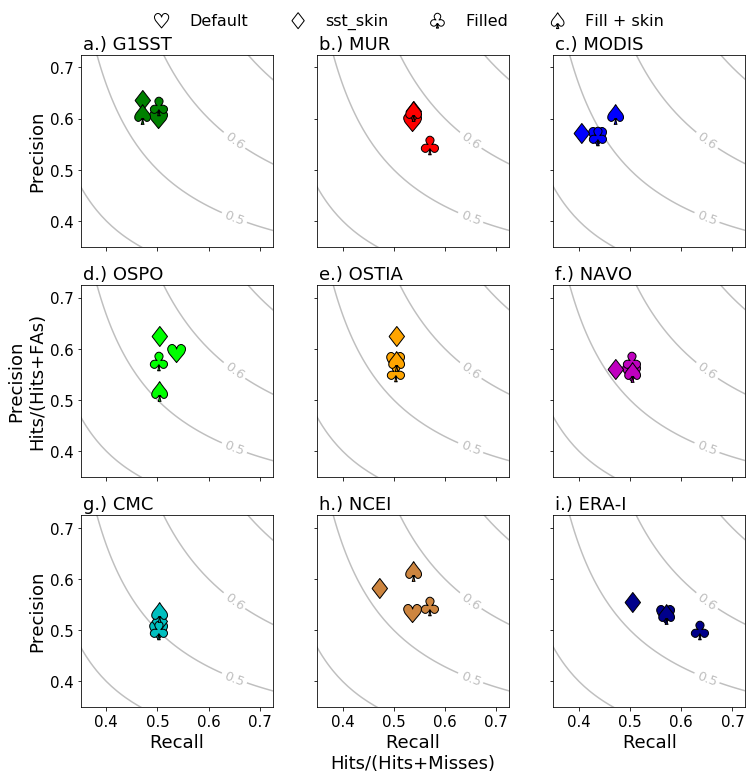

In [20]:
cases_plot_order = plt_order_full

show_close = False
rec_2d,prec_2d = np.meshgrid(np.arange(0,1.05,0.01),np.arange(0,1.05,0.01))
fig,ax = plt.subplots(ncols=3,nrows=3,figsize=(12,12),sharey=True,sharex=True)

prev_case = cases_plot_order[0].split('_')[0]
row,col = 0,0
plt_count = 0
plot_lines = True

for cc,case in enumerate(cases_plot_order):
    case_plt_dict = case_dict[case]['d03']
    case_base = case.split('_')[0]
    if case_base != prev_case:
        col += 1
        if col > 2:
            col = 0
            row += 1
        prev_case = case_base
        plt_count += 1
        plot_lines = True
    # MBDA
    meth = 'MBDA'
    marker_size = 400
    ax[row,col].scatter(confusion_matrix_dict[case][meth]['recall'],confusion_matrix_dict[case][meth]['precision'],
               marker=case_plt_dict['marker'], 
               c=case_plt_dict['color'], 
               edgecolor='k', # Colors
               #edgecolor=case_plt_dict['color'], # Colors
               #label=case_plt_dict['name'],
               s=marker_size,zorder=5,clip_on=False)
    
    
    if plot_lines:
        f1_lines = ax[row,col].contour(rec_2d,prec_2d,2.0*((prec_2d*rec_2d)/(prec_2d+rec_2d)),
                                 levels=np.arange(0.1,1,0.1),colors='k',alpha=0.25,zorder=0)
        lbl_locs = []
        for ll,f1l in enumerate(f1_lines.levels):
            if ll == 8:
                x_loc = 0.65
            else:
                x_loc = 0.65
            y_loc = ((f1l/2.0)*(x_loc))/(x_loc - f1l/2.0)
            lbl_locs.append((x_loc,y_loc))
        f1_lbls = plt.clabel(f1_lines,fmt='%1.1f',inline=0,manual=lbl_locs,inline_spacing=1,fontsize=13)
        [txt.set_bbox(dict(boxstyle='square,pad=0.2',fc='w',ec='w',clip_on=True)) for txt in f1_lbls]
        ax[row,col].set_xticks(np.arange(0.1,1.1,0.1))
        ax[row,col].set_yticks(np.arange(0.1,1.1,0.1))
        ax[row,col].set_ylim(0.35,0.725)
        ax[row,col].set_xlim(0.35,0.725)
        ax[row,col].set_aspect('equal')

        if cc == 0:
            order = [0,1,4,2,3,5]
        else:
            order = [0,1,2,3]

        ax[row,col].tick_params(labelsize=15)
        if (row == 2):
            if (col == 1) :
                ax[row,col].set_xlabel('Recall\nHits/(Hits+Misses)',size=18)
            else:
                ax[row,col].set_xlabel('Recall',size=18)
        if (col == 0):
            if (row == 1):
                ax[row,col].set_ylabel('Precision\nHits/(Hits+FAs)',size=18)
            else:
                ax[row,col].set_ylabel('Precision',size=18)
        ax[row,col].text(0.01,1.03,'{}.) {}'.format(ascii_lowercase[plt_count],case_plt_dict['name']),
                         size=18,transform=ax[row,col].transAxes)
    plot_lines = False

markers = ['$♥$','$♦$','$\\clubsuit$','$\\spadesuit$']
leg_labels = ['Default','sst_skin','Filled','Fill + skin']
for mm in range(0,4):
    ax[0,0].scatter(-1, 0,
                    marker=markers[mm], s=marker_size,
                    c='none', ec='k', # Colors
                    label=leg_labels[mm],
                    zorder=cc+3)

ax[0,0].legend(frameon=False,fontsize=16,
           loc=(0.30,1.1),markerscale=0.8,
           ncol=4)
if save_figs:
    plt_str = 'MBDA_F1'
    if show_close: plt_str += '_close'
    plt.savefig('{}{}.png'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}{}.pdf'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

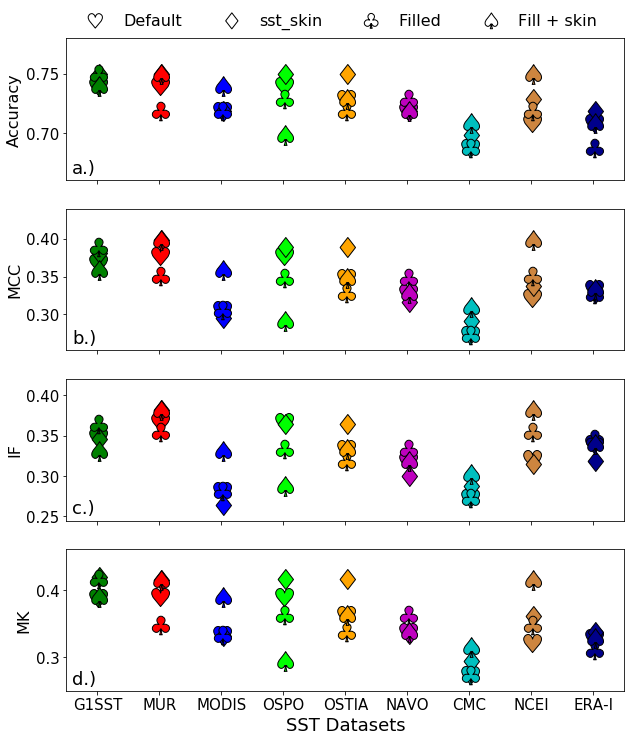

In [22]:
cases_plot_order = plt_order_full

show_close = False
rec_2d,prec_2d = np.meshgrid(np.arange(0,1.05,0.01),np.arange(0,1.05,0.01))

metrics_list = ['CSI','Accuracy','MCC','IF','MK']
metrics_list = ['Accuracy','MCC','IF','MK']

fig,ax = plt.subplots(ncols=1,nrows=len(metrics_list),figsize=(10,12),sharey=False,sharex=True)

prev_case = cases_plot_order[0].split('_')[0]
row,col = 0,0
plt_count = 0
plot_lines = True

xlabels = [case_dict[cases_plot_order[0]]['d03']['name']]

for cc,case in enumerate(cases_plot_order):
    case_plt_dict = case_dict[case]['d03']
    case_base = case.split('_')[0]
    if case_base != prev_case:
        col += 1
        if col > 2:
            col = 0
            row += 1
        prev_case = case_base
        plt_count += 1
        plot_lines = True
        xlabels.append(case_plt_dict['name'])
    # MBDA
    meth = 'MBDA'
    marker_size = 400

    
    for mm, metric in enumerate(metrics_list):

        ax[mm].scatter(plt_count,confusion_matrix_dict[case][meth][metric],
                      marker=case_plt_dict['marker'], 
                      c=case_plt_dict['color'], 
                      edgecolor='k', # Colors
                      s=marker_size,zorder=5,clip_on=False)
        
        
        
for mm in range(0,4):
    ax[0].scatter(-1, 0.74,
                    marker=markers[mm], s=marker_size,
                    c='none', ec='k', # Colors
                    label=leg_labels[mm],
                    zorder=cc+3)

ax[0].legend(frameon=False,fontsize=16,
           loc=(0.01,1.02),markerscale=0.8,
           ncol=4)

ax[0].set_ylim(0.66,0.78)
plt.xticks(np.arange(0,plt_count+1),xlabels)
plt.xlabel('SST Datasets',size=18)
for mm, metric in enumerate(metrics_list):
    ax[mm].tick_params(labelsize=15)
    ax[mm].set_ylabel(metric,size=16)
    ax[mm].set_xlim(-0.5,8.5)
    ax[mm].text(0.01,0.02,'{}.)'.format(ascii_lowercase[mm]),
                         size=18,transform=ax[mm].transAxes,ha='left',va='bottom')
    
if save_figs:
    plt_str = 'MBDA_SkillMetrics'
    if show_close: plt_str += '_close'
    plt.savefig('{}{}.png'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}{}.pdf'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Compare LBI to MBDA:

In [34]:
# What cutoff data do we want...
LBI_cut = 3.5

sst_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/SST/'
include_breezes = False
#LBI_f = open('{}LBI_predictions.txt'.format(sst_dir),'r')
LBI_f = open('{}LBI_predictions_IAD_cut{}.txt'.format(sst_dir,str(LBI_cut).replace('.','p')))
LBI_bb_days = {}
LBI_f.readline()
for line in LBI_f:
    line = line.split(',')
    case = line[0]
    breezes = int(line[1])
    days = int(line[2].replace('\n',''))
    LBI_bb_days[case] = {'breezes':breezes,'days':days}

p1_min = 99
p1_max = 0
p2_min = 99
p2_max = 0
for cc,case in enumerate(LBI_bb_days.keys()):
    num_breezes = LBI_bb_days[case]['breezes']
    num_days = LBI_bb_days[case]['days']
    
    if include_breezes:
        if num_breezes > p1_max: p1_max = num_breezes
        if num_breezes < p1_min: p1_min = num_breezes

    if num_days > p2_max: p2_max = num_days
    if num_days < p2_min: p2_min = num_days

for cc,case in enumerate(cases_plot_order):
    num_breezes = mbda_bb_days[case]['breezes']
    if num_breezes > p1_max: p1_max = num_breezes
    if num_breezes < p1_min: p1_min = num_breezes
    
    num_days = mbda_bb_days[case]['days']
    if num_days > p2_max: p2_max = num_days
    if num_days < p2_min: p2_min = num_days
    
print(p1_min,p1_max)
print(p2_min,p2_max)

21 38
5 13


LBI_Comparison_cut3p5


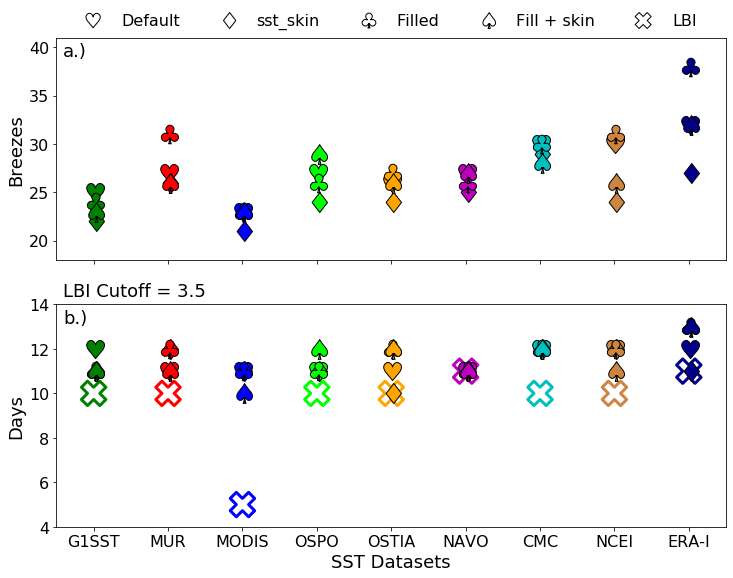

In [35]:
fig,ax = plt.subplots(nrows=2,figsize=(12,9),sharex=True)
plt_count = 0
prev_case = ''
#prev_case = cases_plot_order[0].split('_')[0]
#xlabels = [case_dict[cases_plot_order[0]]['d03']['name']]
for cc,case in enumerate(cases_plot_order):
    case_base = case.split('_')[0]
    case_plt_dict = case_dict[case]['d03']

    if case_base != prev_case:
        prev_case = case_base
        plt_count += 1
        plot_lines = True
        xlabels.append(case_plt_dict['name'])
        lbi_case_str = case_base
        if case_base == 'MUR1K':
            lbi_case_str = 'MUR'
        elif case_base == 'OSPOG':
            lbi_case_str = 'OSPO'
        elif case_base == 'NAVOK':
            lbi_case_str = 'NAVO'
        elif case_base == 'CMC01':
            lbi_case_str = 'CMC'
        elif case_base == 'NCEIA':
            lbi_case_str = 'NCEI'
        elif case_base == 'DEFLT':
            lbi_case_str = 'ERAI'
            
        if include_breezes:
            ax[0].scatter(plt_count,LBI_bb_days[lbi_case_str]['breezes'],
                          marker='X', 
                          c='None', lw=3.0,
                          edgecolor=case_plt_dict['color'], # Colors
                          s=marker_size*1.5,zorder=5,clip_on=False)
        ax[1].scatter(plt_count,LBI_bb_days[lbi_case_str]['days'],
                      marker='X', 
                      c='None', lw=3.0,
                      edgecolor=case_plt_dict['color'], # Colors
                      s=marker_size*1.5,zorder=5,clip_on=False)
        
    ax[0].scatter(plt_count,mbda_bb_days[case]['breezes'],
                  marker=case_plt_dict['marker'], 
                  c=case_plt_dict['color'], 
                  edgecolor='k', # Colors
                  s=marker_size,zorder=5,clip_on=False)
    ax[1].scatter(plt_count,mbda_bb_days[case]['days'],
                  marker=case_plt_dict['marker'], 
                  c=case_plt_dict['color'], 
                  edgecolor='k', # Colors
                  s=marker_size,zorder=5,clip_on=False)
    
    
for mm in range(0,4):
    ax[0].scatter(-1, 0.34,
                  marker=markers[mm], s=marker_size,
                  c='none', ec='k', # Colors
                  label=leg_labels[mm],
                  zorder=cc+3)
ax[0].scatter(-1, 0.34,
              marker='X', s=marker_size,
              c='none', ec='k', # Colors
              label='LBI',
              zorder=cc+3)

ax[0].legend(frameon=False,fontsize=16,
           loc=(0.02,1.01),markerscale=0.8,
           ncol=5)


plt.xticks(np.arange(1,plt_count+2),xlabels)
plt.xlabel('SST Datasets',size=18)
ax[0].set_ylabel('Breezes',size=18)
ax[1].set_ylabel('Days',size=18)

for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_xlim(0.5,9.5)
    ax[axi].text(0.01,0.98,'{}.)'.format(ascii_lowercase[axi]),
                 size=18,transform=ax[axi].transAxes,ha='left',va='top')
    
ax[0].set_ylim(p1_min-3,p1_max+3)
ax[1].set_ylim(p2_min-1,p2_max+1)

ax[1].text(0.01,1.02,'LBI Cutoff = {0:2.1f}'.format(LBI_cut),
                 size=18,transform=ax[axi].transAxes,ha='left',va='bottom')

if save_figs:
    plt_str = 'LBI_Comparison_cut{}'.format(str(LBI_cut).replace('.','p'))
    print(plt_str)
    plt.savefig('{}{}.png'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}{}.pdf'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    
plt.show()

# Testing LBI Cutoff:

In [24]:
# What cutoff data do we want...
LBI_cuts = [3.0,4.0,5.0,6.0]


sst_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/SST/'
include_breezes = False
#LBI_f = open('{}LBI_predictions.txt'.format(sst_dir),'r')

p1_min = 99
p1_max = 0
p2_min = 99
p2_max = 0

LBI_bb_days = {}

for LBI_cut in LBI_cuts:
    LBI_bb_days[LBI_cut] = {}
    LBI_f = open('{}LBI_predictions_IAD_cut{}.txt'.format(sst_dir,str(LBI_cut).replace('.','p')))
    LBI_f.readline()
    for line in LBI_f:
        line = line.split(',')
        case = line[0]
        breezes = int(line[1])
        days = int(line[2].replace('\n',''))
        LBI_bb_days[LBI_cut][case] = {'breezes':breezes,'days':days}

    for cc,case in enumerate(LBI_bb_days[LBI_cut].keys()):
        num_breezes = LBI_bb_days[LBI_cut][case]['breezes']
        num_days = LBI_bb_days[LBI_cut][case]['days']

        if include_breezes:
            if num_breezes > p1_max: p1_max = num_breezes
            if num_breezes < p1_min: p1_min = num_breezes

        if num_days > p2_max: p2_max = num_days
        if num_days < p2_min: p2_min = num_days

for cc,case in enumerate(cases_plot_order):
    num_breezes = mbda_bb_days[case]['breezes']
    if num_breezes > p1_max: p1_max = num_breezes
    if num_breezes < p1_min: p1_min = num_breezes

    num_days = mbda_bb_days[case]['days']
    if num_days > p2_max: p2_max = num_days
    if num_days < p2_min: p2_min = num_days
    
print(p1_min,p1_max)
print(p2_min,p2_max)

21 38
4 13


LBI_Comparison_cut6p0


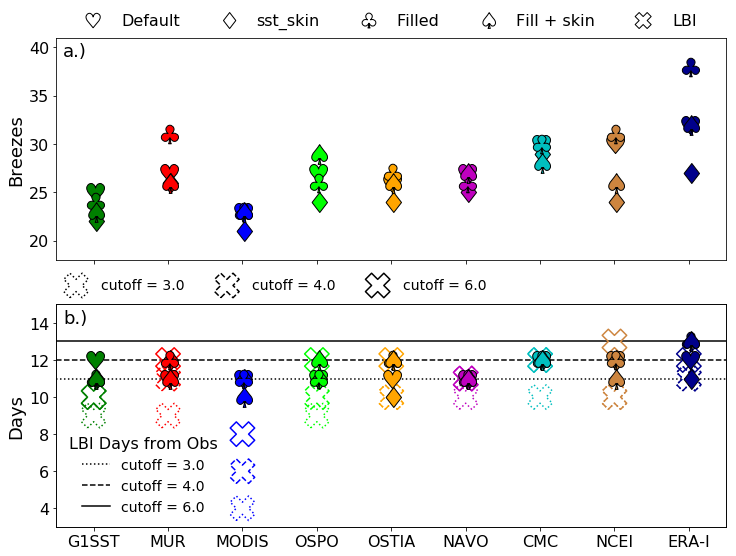

In [25]:
fig,ax = plt.subplots(nrows=2,figsize=(12,9),sharex=True)
plt_count = 0
prev_case = ''

ax2 = ax[1].twinx()
ax2.get_yaxis().set_visible(False)

new_LBI_cuts = [3.0,4.0,6.0]

for cc,case in enumerate(cases_plot_order):
    case_base = case.split('_')[0]
    case_plt_dict = case_dict[case]['d03']

    if case_base != prev_case:
        prev_case = case_base
        plt_count += 1
        plot_lines = True
        xlabels.append(case_plt_dict['name'])
        lbi_case_str = case_base
        if case_base == 'MUR1K':
            lbi_case_str = 'MUR'
        elif case_base == 'OSPOG':
            lbi_case_str = 'OSPO'
        elif case_base == 'NAVOK':
            lbi_case_str = 'NAVO'
        elif case_base == 'CMC01':
            lbi_case_str = 'CMC'
        elif case_base == 'NCEIA':
            lbi_case_str = 'NCEI'
        elif case_base == 'DEFLT':
            lbi_case_str = 'ERAI'
            
        case_color = case_plt_dict['color']
        for lc,LBI_cut in enumerate(new_LBI_cuts):
            if lc == 0:
                ec = case_color
                mc = 'None'
                LBI_ls = ':'
            elif lc == 1:
                ec = case_color
                mc = 'k' 
                LBI_ls = '--'
            elif lc == 2:
                ec = 'k'
                mc = case_color
                LBI_ls = '-'
            elif lc == 3:
                ec = 'None'
                mc = case_color
                LBI_ls = '-.'

            if include_breezes:
                ax[0].scatter(plt_count,LBI_bb_days[LBI_cut][lbi_case_str]['breezes'],
                              marker='X', 
                              c='None', lw=3.0,ls=LBI_ls,
                              edgecolor=ec, # Colors
                              s=marker_size*1.5,zorder=5,clip_on=False)
            ax[1].scatter(plt_count,LBI_bb_days[LBI_cut][lbi_case_str]['days'],
                          marker='X', 
                          c='None', lw=1.5,ls=LBI_ls,
                          edgecolor=case_color, # Colors
                          s=marker_size*1.5,zorder=5,clip_on=False)
            if cc == 0:
                if mc != 'None': mc = 'k'
                if ec != 'None': ec = 'k'
                ax2.scatter(-10.0,LBI_bb_days[LBI_cut]['obs']['days'],
                            marker='X', label='cutoff = {}'.format(LBI_cut),
                            c='None', lw=1.5,ls=LBI_ls,
                            edgecolor='k', # Colors
                            s=marker_size*1.5,zorder=5,clip_on=True)
                ax[1].axhline(LBI_bb_days[LBI_cut]['obs']['days'],c='k',
                              label='cutoff = {}'.format(LBI_cut),
                              ls=LBI_ls)
        
    ax[0].scatter(plt_count,mbda_bb_days[case]['breezes'],
                  marker=case_plt_dict['marker'], 
                  c=case_plt_dict['color'], 
                  edgecolor='k', # Colors
                  s=marker_size,zorder=5,clip_on=False)
    ax[1].scatter(plt_count,mbda_bb_days[case]['days'],
                  marker=case_plt_dict['marker'], 
                  c=case_plt_dict['color'], 
                  edgecolor='k', # Colors
                  s=marker_size,zorder=5,clip_on=False)
    
    
for mm in range(0,4):
    ax[0].scatter(-1, 0.34,
                  marker=markers[mm], s=marker_size,
                  c='none', ec='k', # Colors
                  label=leg_labels[mm],
                  zorder=cc+3)
ax[0].scatter(-1, 0.34,
              marker='X', s=marker_size,
              c='none', ec='k', # Colors
              label='LBI',
              zorder=cc+3)

ax[0].legend(frameon=False,fontsize=16,
           loc=(0.02,1.01),markerscale=0.8,
           ncol=5)


plt.xticks(np.arange(1,plt_count+2),xlabels)
plt.xlabel('SST Datasets',size=18)
ax[0].set_ylabel('Breezes',size=18)
ax[1].set_ylabel('Days',size=18)

for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_xlim(0.5,9.5)
    ax[axi].text(0.01,0.98,'{}.)'.format(ascii_lowercase[axi]),
                 size=18,transform=ax[axi].transAxes,ha='left',va='top')
    
ax[0].set_ylim(p1_min-3,p1_max+3)
ax[1].set_ylim(p2_min-1,p2_max+2)
#ax2.set_xlim(0.5,9.5)
#ax[1].set_xlim(0.5,9.5)
legend = ax[1].legend(frameon=False,fontsize=14)
legend.set_title('LBI Days from Obs',prop={'size':16})

ax2.legend(frameon=False,ncol=3,loc=(0.0,1.03),fontsize=14)

if save_figs:
    plt_str = 'LBI_Comparison_cut{}'.format(str(LBI_cut).replace('.','p'))
    print(plt_str)
    plt.savefig('{}{}.png'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}{}.pdf'.format(save_dir,plt_str), bbox_inches = 'tight',pad_inches = 0.1)
    
plt.show()